In [41]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import defaultdict
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

In [42]:
class Vehicle:
    """Define vehicle attributes and rules to be implemented"""
    def __init__(self, x_position, speed, max_speed, length, width, road_designation, vehicle_type, current_row, lane_changing_prob, passenger_capacity):
        self.x_position = x_position #position along the length of the road (x position)
        self.speed = speed #number of cells the vehicle will move per timestep
        self.max_speed = max_speed #maximum speed
        self.braking_prob = 0.01 #probability of random slowdown
        self.length = length #length of the vehicle is the number of cells the vehicle occupies along the length of the road
        self.width = width #width of the vehicle is the number of cells the vehicle occupies along the width of the road
        self.road_designation = road_designation #whether inside or outside
        self.vehicle_type = vehicle_type #type of vehicle is determined by the size and behavior
        self.current_row = current_row #also known as the y position of the right side of the vehicle
        self.lane_changing_prob = lane_changing_prob #probability that a vehicle will transfer lane
        self.passenger_capacity = passenger_capacity
        self.occupied_seats = np.random.randint(0, passenger_capacity + 1)
        self.passengers = [Passenger(None, initially_on_vehicle=True) for _ in range(self.occupied_seats)]
        self.unoccupied_seats = self.passenger_capacity - self.occupied_seats
        
    def accelerate(self):
        """Increases vehicle's speed by 1 cell, up to the maximum speed"""
        if self.speed < self.max_speed:
            self.speed += 1

    def lane_changing(self, gap_distance):
        """attempts to change lanes based on vehicle type and lane availability
        Here, we define a lane as a space of 2 cells wide. We assume a two-lane road(4 cells wide, with 1 cell wide passenger holding area beside row 0).
        We assume that each half lane is an array, imagine a vertical stack of arrays, indexing is from top to bottom (0-4). Right side is the bottom."""
        new_row = self.current_row
        if self.speed > gap_distance:
            if self.current_row == 0:
                new_row = self.current_row + 2
            elif self.current_row == 2:
                new_row = self.current_row - 2
        #Check for space on the lane of interest
        if self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, new_row:new_row + self.width].sum() == 0:
            self.current_row = new_row

    def decelerate(self, gap_distance):
        """decreases vehicle's speed to match the gap distance, given the speed>gap distance"""
        if self.speed > gap_distance:
            self.speed = gap_distance

    def braking(self):
        """Mimics random slowdown, randomly decreases vehicle's speed based on braking probability """
        if np.random.rand() < self.braking_prob and self.speed > 0:
            self.speed -= 1

    def move(self):
        """implements movement"""
        self.x_position = (self.x_position + self.speed) % self.road_designation.road_length

    def pick_up_passengers(self, passengers_at_sidewalk):
        """When jeep position on lane 0 is adjacent to an occupied position on the sidewalk, jeepney stops, then picks up all the passengers that it can pick up"""
        for passenger in passengers_at_sidewalk:
            if self.unoccupied_seats > 0:
                print(f"Picking up passenger at position {passenger.location}")
                passenger.on_vehicle = True
                self.passengers.append(passenger)
                self.occupied_seats += 1
                self.unoccupied_seats -= 1
                print(f"Vehicle now has {self.occupied_seats} occupied seats and {self.unoccupied_seats} unoccupied seats")

    def reset_occupancy(self):
        """This method resets occupancy when the vehicle reaches the end"""
        self.passengers = [Passenger(None, initially_on_vehicle=True) for _ in range(self.occupied_seats)]
        self.unoccupied_seats = self.passenger_capacity - self.occupied_seats

In [43]:
class Passenger:
    def __init__(self, location, initially_on_vehicle=False):
        self.location = location # sets initial location
        self.waiting_time = 0
        self.travel_time = 0
        self.on_vehicle = False #whether the passenger is on the vehicle or not
        self.initially_on_vehicle = False #whether the passenger is already on the vehicle or not

    def increment_waiting_time(self):
        """increments the waiting_time by 1 if the passenger is not on the vehicle."""
        if not self.on_vehicle:
            self.waiting_time += 1

    def increment_travel_time(self):
        """increments the travel time by 1 if the passenger is on the vehicle."""
        if self.on_vehicle:
            self.travel_time += 1

    def __repr__(self):
        """String representation of the passenger - for debugging """
        return f"Passenger(waiting_time={self.waiting_time}, travel_time={self.travel_time}, initially_on_vehicle={self.initially_on_vehicle})"

In [44]:
class Road:
    def __init__(self, road_length, road_width, speed_limit):
        self.road_length = road_length
        self.road_width = road_width
        self.speed_limit = speed_limit
        self.road_occupancy = np.zeros((road_length, road_width))

In [45]:
class Sidewalk:
    def __init__(self, sidewalk_length, passenger_spots_per_cell):
        self.sidewalk_length = sidewalk_length
        self.sidewalk_width = 1
        self.passenger_spots = passenger_spots_per_cell
        #initialize the sidewalk occupancy as a matrix of matrices
        self.sidewalk_occupancy = np.array([[np.full(passenger_spots_per_cell, None) for _ in range(self.sidewalk_width)] for _ in range(sidewalk_length)])
        
    def __repr__(self):
        return f"Sidewalk(occupancy={self.sidewalk_occupancy})"

In [50]:
class IntraRoadSimulator:
    def __init__(self, road):
        self.road = road  # Store the road instance
        self.vehicles = []  # List to store vehicle instances
        self.passengers = []  # List to store passenger instances
        self.sidewalk = Sidewalk(road.road_length, passenger_spots_per_cell = 10)
        self.occupancy_history = []  # List to store the history of road occupancy states
        self.passenger_throughput = 0  # Counter for the number of passengers transported
        self.vehicle_throughput = 0
        self.slowdown_counts = 0  # Counter for the number of slowdowns due to traffic

    def update_occupancy(self):
        self.road.road_occupancy.fill(0)
        for vehicle in self.vehicles:
            x_start = vehicle.x_position
            x_end = (vehicle.x_position + vehicle.length) % self.road.road_length
            y_start = vehicle.current_row
            y_end = min(vehicle.current_row + vehicle.width, self.road.road_width)
            if x_start < x_end:
                self.road.road_occupancy[x_start:x_end, y_start:y_end] = 1
            else:
                self.road.road_occupancy[x_start:, y_start:y_end] = 1
                self.road.road_occupancy[:x_end, y_start:y_end] = 1
        self.occupancy_history.append(self.road.road_occupancy.copy)

    def initialize_vehicles(self, density, truck_fraction, truck_lane_change_prob, jeep_lane_change_prob):
        A, B = 7 * 2, 3 * 2  # Constants for truck and jeep area
        L, W = self.road.road_length, self.road.road_width  # Road dimensions
        N = int(density * L * W * (truck_fraction / A + (1 - truck_fraction) / B))  # Number of vehicles based on density and truck fraction
        for _ in range(N):
            vehicle_type = 'truck' if np.random.rand() < truck_fraction else 'jeep'  # Randomly decide vehicle type
            length = 7 if vehicle_type == 'truck' else 3
            width = 2
            x_position = np.random.randint(0, self.road.road_length)  # Random initial position
            speed = np.random.randint(1, self.road.speed_limit + 1)
            passenger_capacity = 20 if vehicle_type == 'jeep' else 0
            lane_changing_prob = truck_lane_change_prob if vehicle_type == 'truck' else jeep_lane_change_prob
            current_row = 2 if vehicle_type == 'truck' else 0
            if self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width].sum() == 0:
                new_vehicle = Vehicle(x_position, speed, self.road.speed_limit, length, width, self.road, vehicle_type, current_row, lane_changing_prob, passenger_capacity)
                self.vehicles.append(new_vehicle)  # Add vehicle to the list
                self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width] = 1  # Mark vehicle position on road occupancy grid

    def gap_distance(self, vehicle, vehicle_lane_to_be_checked):
        current_x_position = vehicle.x_position
        max_distance = min(vehicle.speed, self.road.road_length - current_x_position - vehicle.length)  # Maximum possible gap distance
        lane_row_1 = vehicle_lane_to_be_checked
        lane_row_2 = lane_row_1 + 1
        gap_distance_row_1 = max_distance
        gap_distance_row_2 = max_distance
        for distance in range(1, max_distance + 1):
            next_x_position = current_x_position + vehicle.length + distance
            if next_x_position >= self.road.road_length or self.road.road_occupancy[next_x_position, vehicle.current_row] == 1:
                gap_distance_row_1 = distance - 1  # Calculate gap distance in current lane
                break
        for distance in range(1, max_distance + 1):
            next_x_position = current_x_position + vehicle.length + distance
            if next_x_position >= self.road.road_length or self.road.road_occupancy[next_x_position, vehicle.current_row] == 1:
                gap_distance_row_2 = distance - 1  # Calculate gap distance in adjacent lane
                break
        return min(gap_distance_row_1, gap_distance_row_2)  # Return the minimum gap distance

    def passenger_arrival(self, arrival_rate):
        for x in range(self.road.road_length):
            if np.random.rand() < arrival_rate:  # Determine if a passenger arrives at this location
                for i in range(self.sidewalk.passenger_spots):
                    if self.sidewalk.sidewalk_occupancy[x][0][i] is None:  # Find an empty spot on the sidewalk
                        new_passenger = Passenger(location=(x, 0))
                        self.sidewalk.sidewalk_occupancy[x][0][i] = new_passenger  # Place the new passenger on the sidewalk
                        self.passengers.append(new_passenger)  # Add the new passenger to the list
                        break
                        
    def record_throughput(self, vehicle):
        num_passengers_on_board = sum(1 for passenger in vehicle.passengers if passenger.on_vehicle)  # Record only passengers who are on the vehicle
        print(f"Recording throughput for vehicle with {num_passengers_on_board} passengers")
        self.passenger_throughput += num_passengers_on_board
        self.vehicle_throughput += 1
    
    def reset_vehicle(self, vehicle):
        self.record_throughput(vehicle)  # Record the throughput of the vehicle
        print(f"Resetting vehicle with {vehicle.occupied_seats} passengers")

        #clear the vehicle
        for passenger in vehicle.passengers:
            passenger.on_vehicle = False  # Set passengers to not on vehicle
        vehicle.passengers = []  # Clear passengers list
        vehicle.occupied_seats = 0
        vehicle.unoccupied_seats = vehicle.passenger_capacity

        #reload the vehicle with passengers
        vehicle.occupied_seats = np.random.randint(0, vehicle.passenger_capacity + 1)
        vehicle.passengers = [Passenger(None, initially_on_vehicle=True) for _ in range(vehicle.occupied_seats)]  # Reset passengers
        vehicle.unoccupied_seats = vehicle.passenger_capacity - vehicle.occupied_seats  # Reset unoccupied seats
         # Move the vehicle to the start if space is available
        if self.road.road_occupancy[0:vehicle.length, vehicle.current_row:vehicle.current_row + vehicle.width].sum() == 0:
            vehicle.x_position = 0  # Wrap around to the start
            self.road.road_occupancy[0:vehicle.length, vehicle.current_row:vehicle.current_row + vehicle.width] = 1

    def simulation_step(self, density, truck_fraction, arrival_rate):
        self.passenger_arrival(arrival_rate)  # Simulate passenger arrival
        
        for passenger in self.passengers:
            passenger.increment_waiting_time()  # Increment waiting time for each passenger

        
        for vehicle in self.vehicles:
            gap_distance_of_own_lane = self.gap_distance(vehicle, vehicle.current_row)  # Calculate gap distance in current lane
            vehicle.accelerate()  # Accelerate the vehicle
            
            if vehicle.speed > gap_distance_of_own_lane:
                other_lane = 2 if vehicle.current_row == 0 else 0  # Determine other lane
                gap_distance_of_other_lane = self.gap_distance(vehicle, other_lane)  # Calculate gap distance in other lane
                if gap_distance_of_other_lane > gap_distance_of_own_lane:
                    if np.random.rand() < vehicle.lane_changing_prob:
                        vehicle.lane_changing(gap_distance_of_other_lane)  # Change lane if possible
                        vehicle.decelerate(gap_distance_of_own_lane)  # Decelerate if necessary
                    else:
                        vehicle.decelerate(gap_distance_of_own_lane)  # Decelerate if not changing lanes
                        vehicle.braking()  # Apply brakes
                        self.slowdown_counts += 1  # Increment slowdown count
                        
            if vehicle.vehicle_type == 'jeep':
                sidewalk_x_position = (vehicle.x_position + vehicle.length // 2) % self.road.road_length
                passengers_at_stop = [p for p in self.sidewalk.sidewalk_occupancy[sidewalk_x_position][0] if p is not None and not p.on_vehicle]
                
                if passengers_at_stop and vehicle.unoccupied_seats > 0:
                    print(f"Jeep at position {vehicle.x_position} picking up passengers")
                    vehicle.decelerate(0)  # Decelerate to pick up passengers
                    vehicle.pick_up_passengers(passengers_at_stop)  # Pick up passengers
                else:
                    pass
                    
            if vehicle.x_position >= self.road.road_length-1: #Greatest fix: redundant +speed and -length on position and road length sides, respectively
                print(f"Vehicle reached end of road at position {vehicle.x_position}")
                vehicle.speed = 0 # Stop the vehicle if it reaches the end of the road
                self.reset_vehicle(vehicle)  # Reset the vehicle
                
            for passenger in vehicle.passengers:
                passenger.increment_travel_time()  # Increment travel time for each passenger
                
            vehicle.move()  # Move the vehicle
            
        self.update_occupancy()  # Update the road occupancy grid

    def visualize(self, step_count):
        plt.figure(figsize=(20, 6))
        plt.imshow(self.road.road_occupancy.T, cmap='gray_r', origin='lower')
        plt.title(f'Step {step_count}')
        plt.xlabel('Road Length')
        plt.ylabel('Lane')
        plt.xticks(range(0, self.road.road_length + 1, 1))
        plt.yticks(range(0, self.road.road_width + 1, 1))
        plt.tight_layout()
        plt.show

    def print_passenger_times(self):
        for i, passenger in enumerate(self.passengers):
            print(f"Passenger {i}: Waiting Time = {passenger.waiting_time}, Travel Time = {passenger.travel_time}, Initially on Vehicle = {passenger.initially_on_vehicle}")

Jeep at position 62 picking up passengers
Picking up passenger at position (63, 0)
Vehicle now has 14 occupied seats and 6 unoccupied seats
Jeep at position 47 picking up passengers
Picking up passenger at position (48, 0)
Vehicle now has 1 occupied seats and 19 unoccupied seats
Jeep at position 51 picking up passengers
Picking up passenger at position (52, 0)
Vehicle now has 8 occupied seats and 12 unoccupied seats
Jeep at position 11 picking up passengers
Picking up passenger at position (12, 0)
Vehicle now has 9 occupied seats and 11 unoccupied seats
Jeep at position 93 picking up passengers
Picking up passenger at position (94, 0)
Vehicle now has 17 occupied seats and 3 unoccupied seats
Jeep at position 78 picking up passengers
Picking up passenger at position (79, 0)
Vehicle now has 11 occupied seats and 9 unoccupied seats
Jeep at position 21 picking up passengers
Picking up passenger at position (22, 0)
Vehicle now has 2 occupied seats and 18 unoccupied seats
Jeep at position 23 

/tmp/ipykernel_103/1123276762.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 6))


Vehicle reached end of road at position 99
Recording throughput for vehicle with 0 passengers
Resetting vehicle with 0 passengers
Jeep at position 99 picking up passengers
Picking up passenger at position (0, 0)
Vehicle now has 9 occupied seats and 11 unoccupied seats
Picking up passenger at position (0, 0)
Vehicle now has 10 occupied seats and 10 unoccupied seats
Vehicle reached end of road at position 99
Recording throughput for vehicle with 7 passengers
Resetting vehicle with 10 passengers
Jeep at position 99 picking up passengers
Picking up passenger at position (0, 0)
Vehicle now has 11 occupied seats and 9 unoccupied seats
Picking up passenger at position (0, 0)
Vehicle now has 12 occupied seats and 8 unoccupied seats
Vehicle reached end of road at position 99
Recording throughput for vehicle with 2 passengers
Resetting vehicle with 12 passengers
Vehicle reached end of road at position 99
Recording throughput for vehicle with 0 passengers
Resetting vehicle with 0 passengers
Jeep 

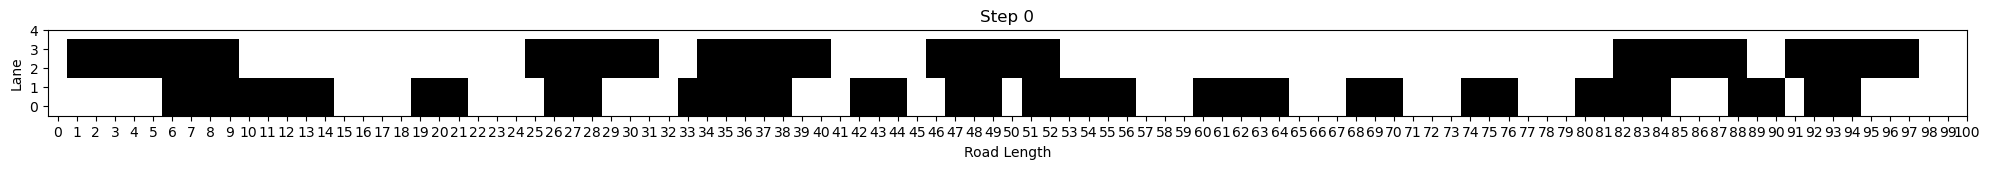

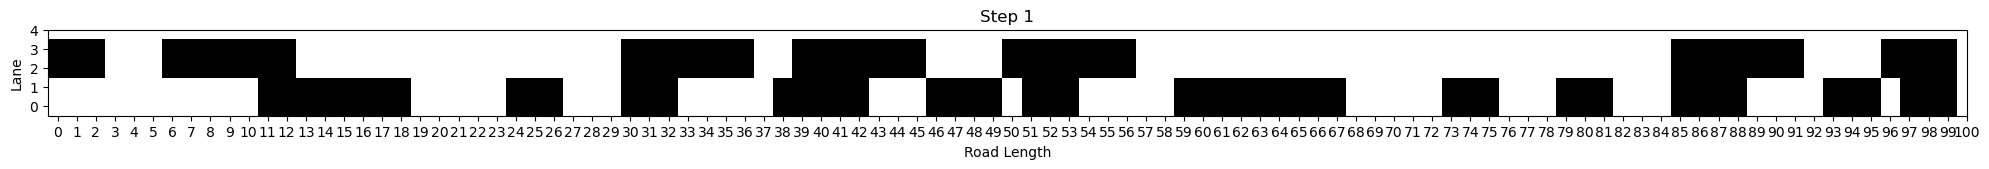

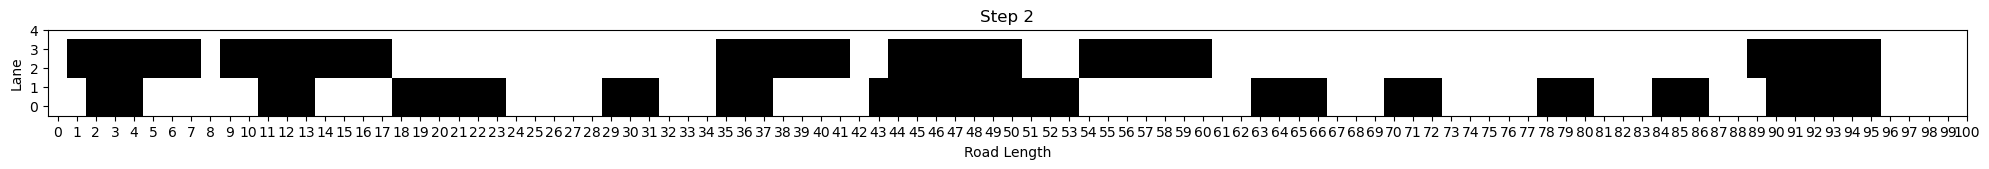

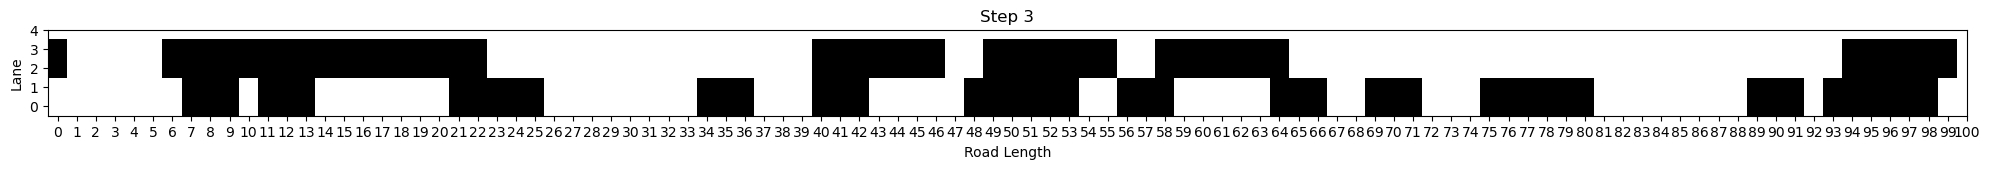

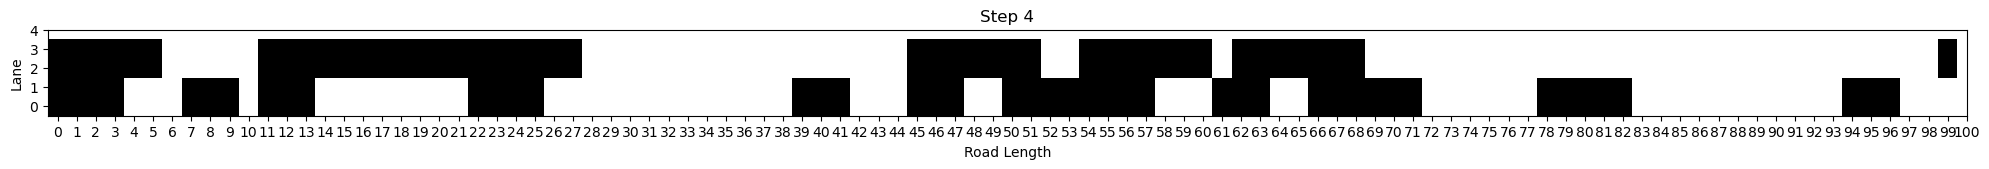

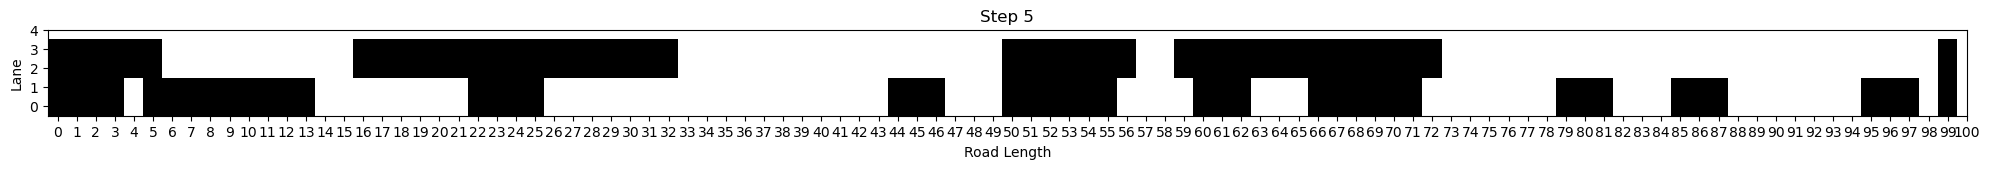

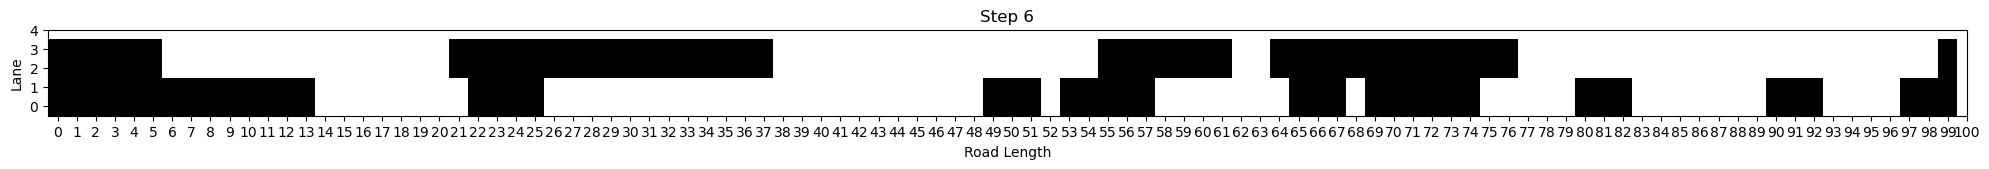

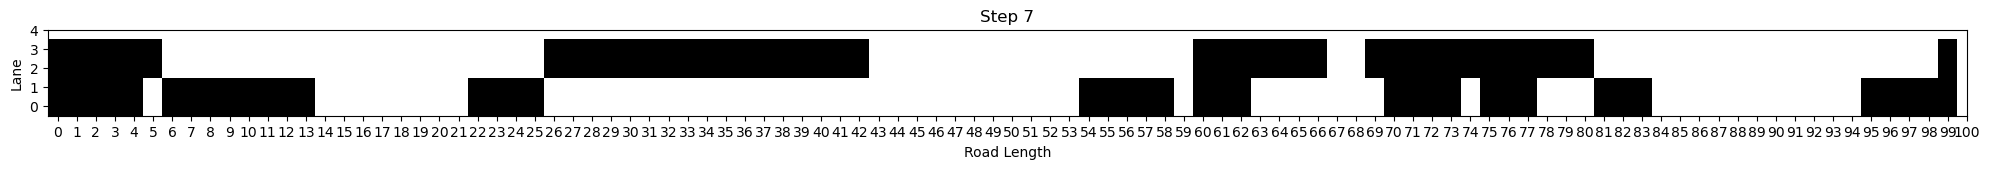

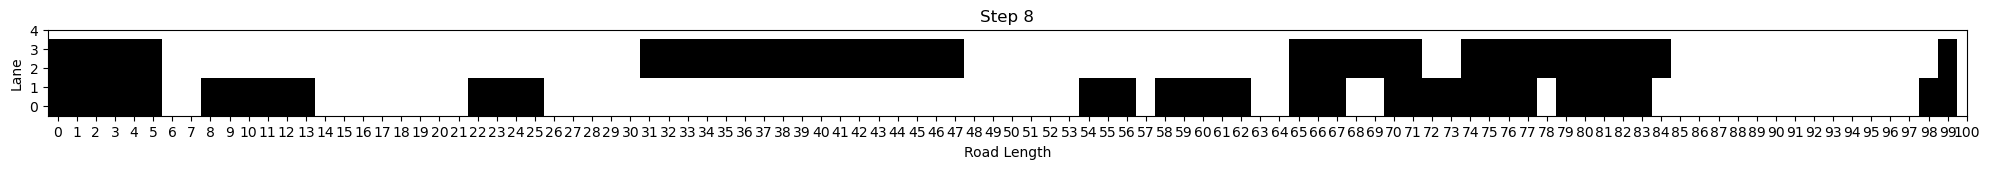

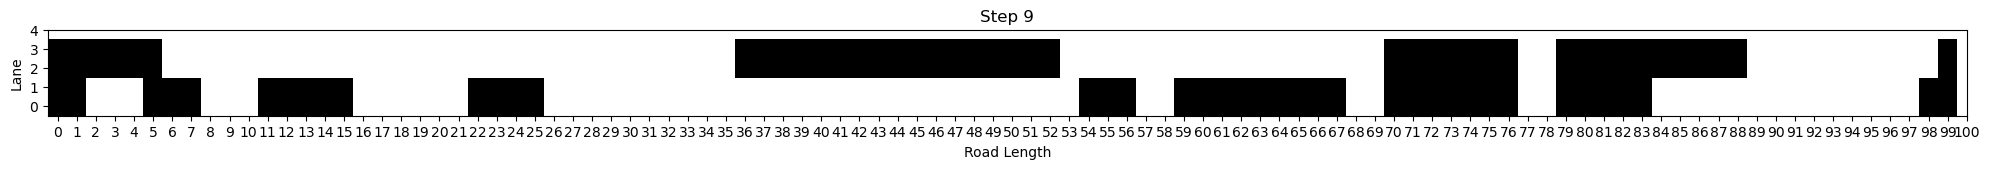

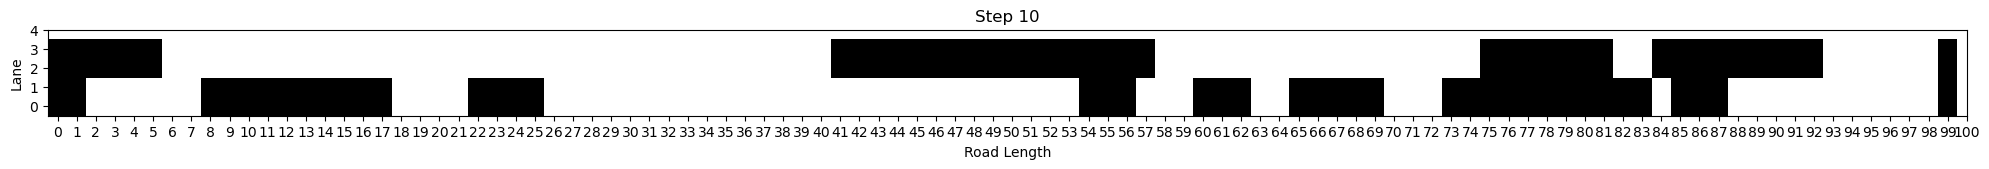

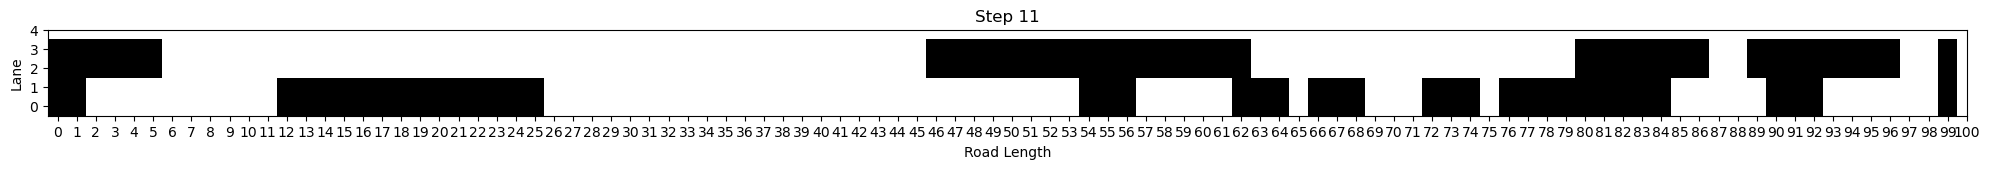

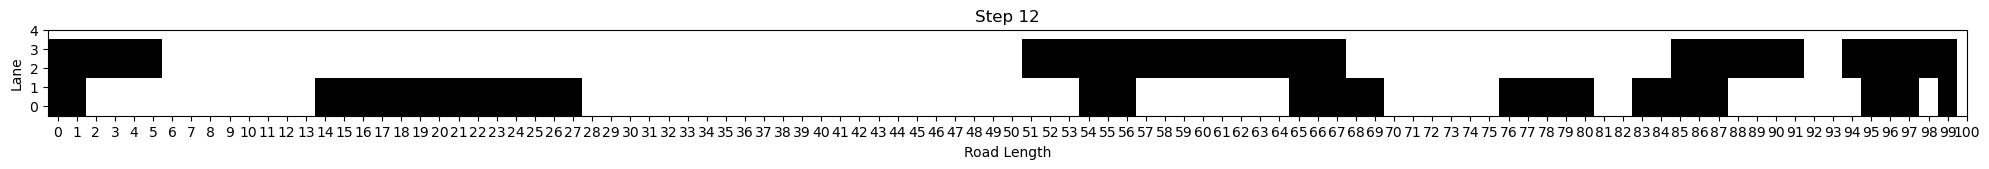

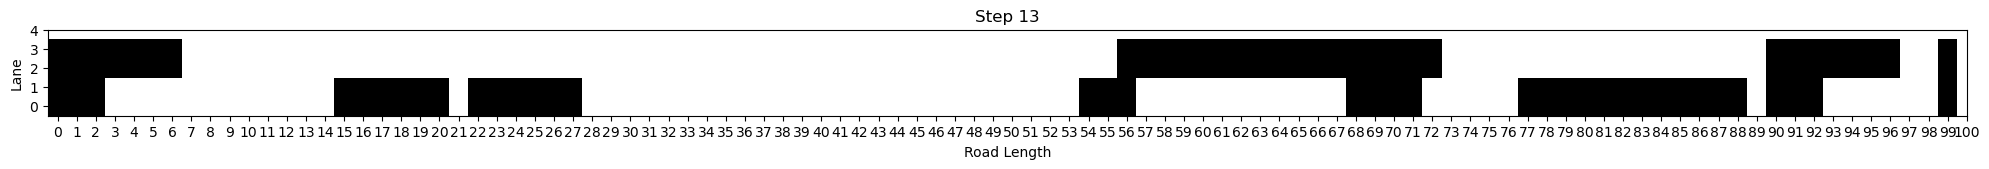

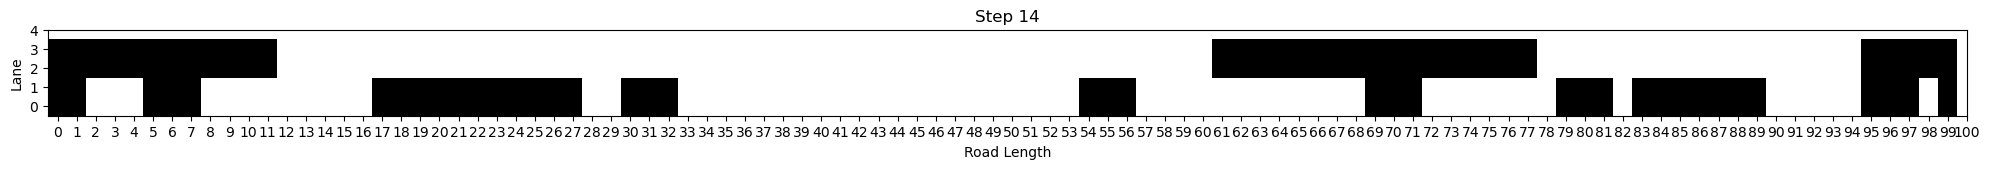

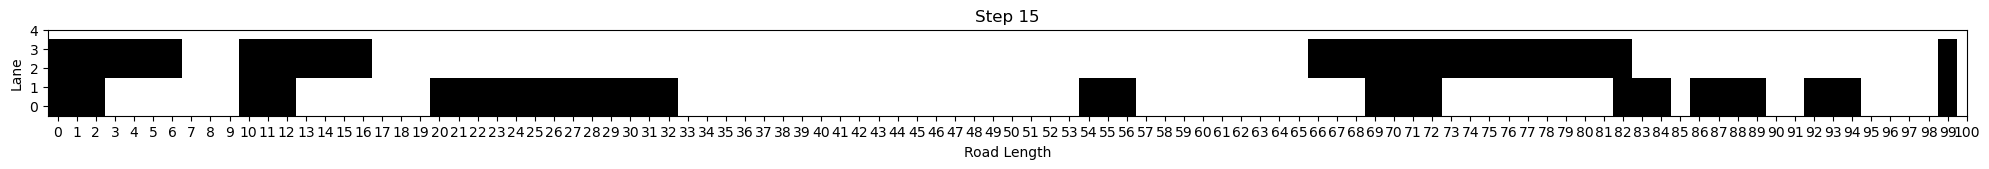

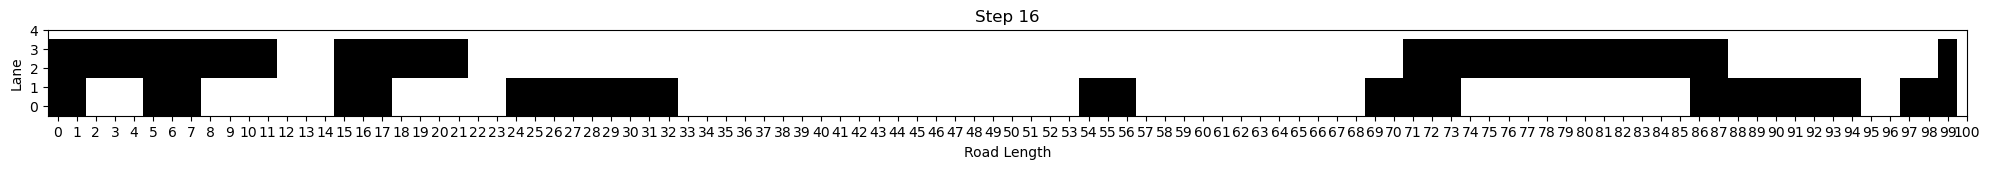

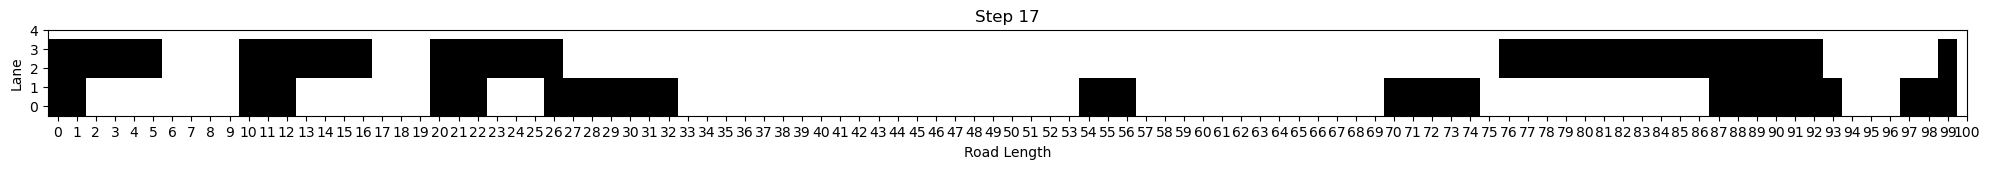

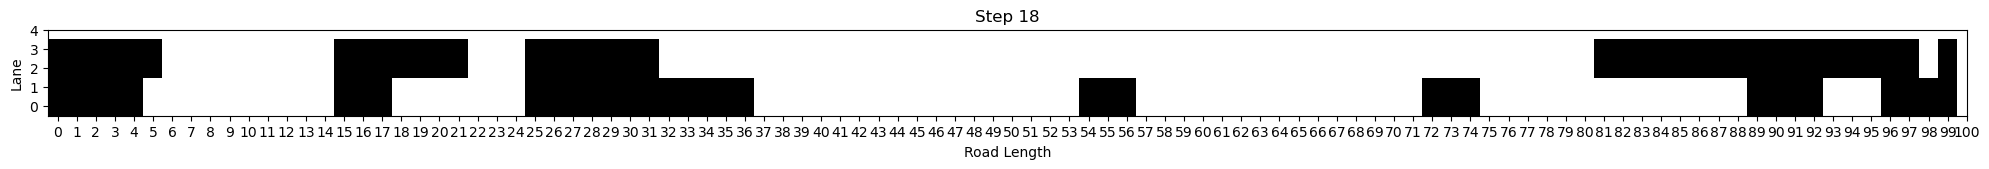

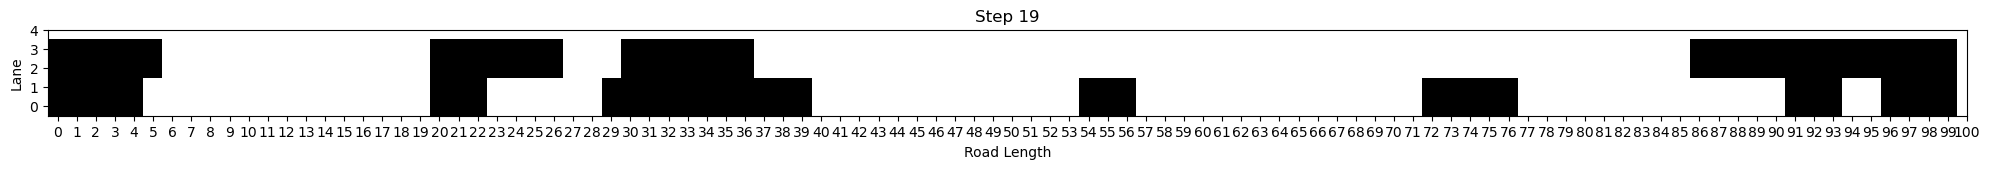

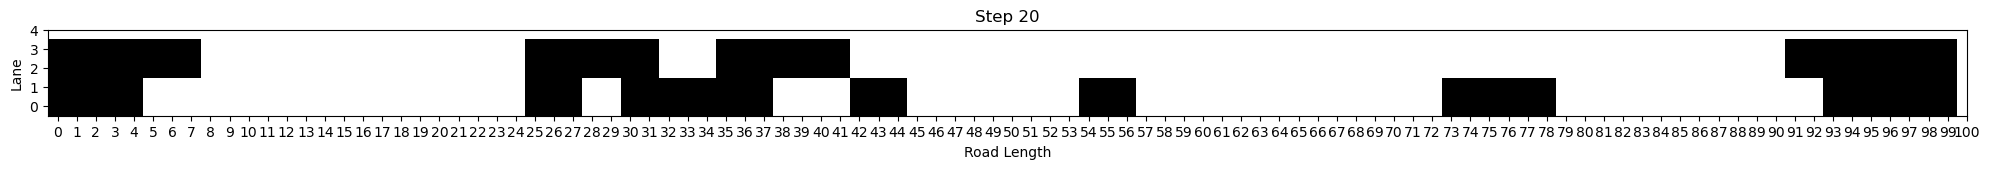

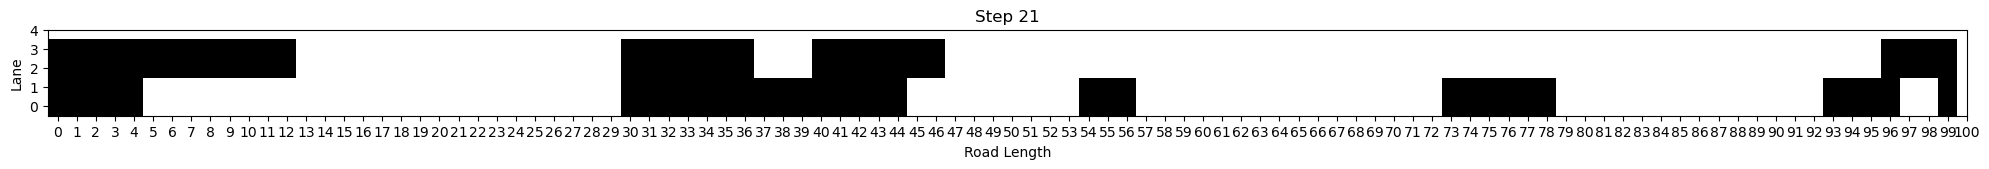

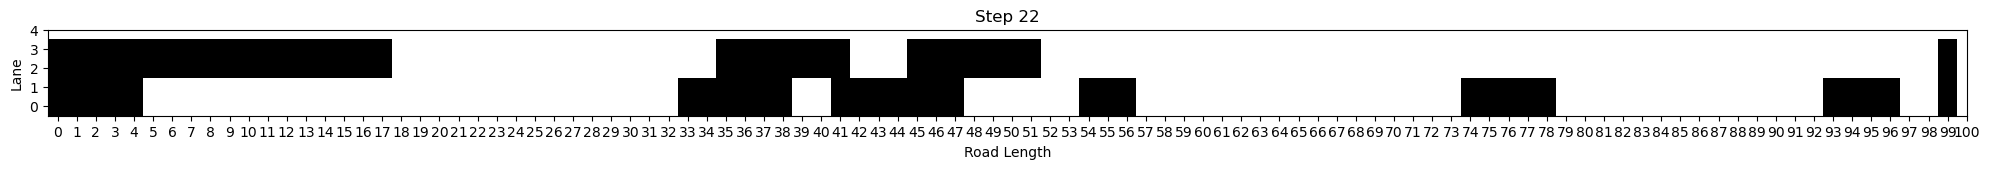

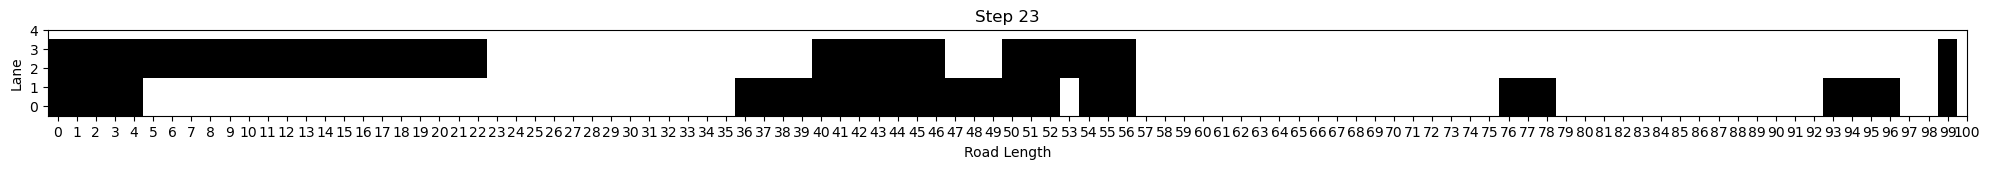

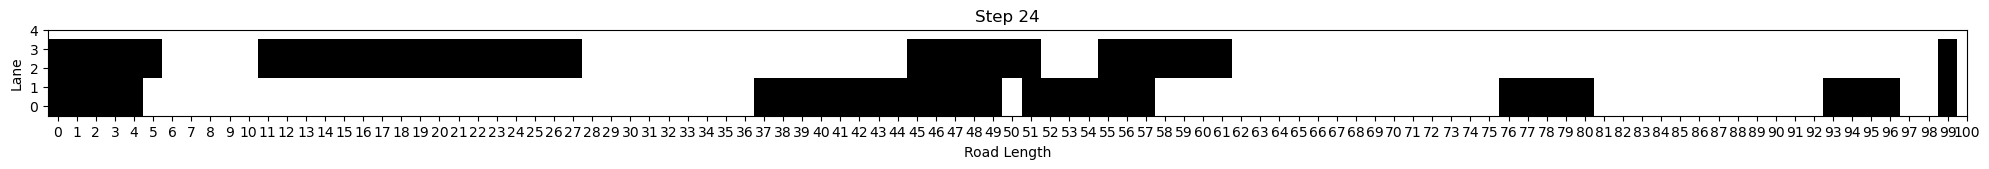

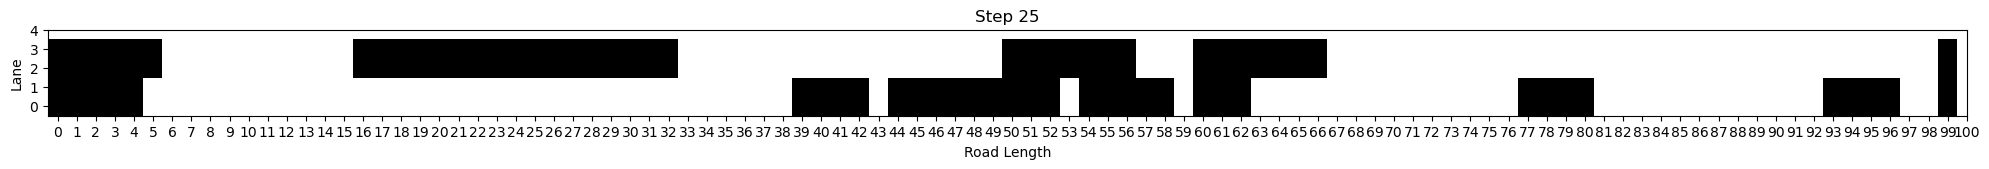

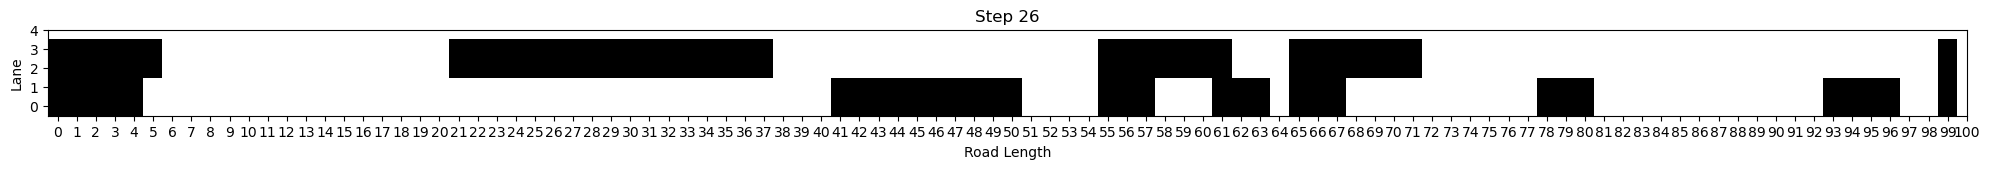

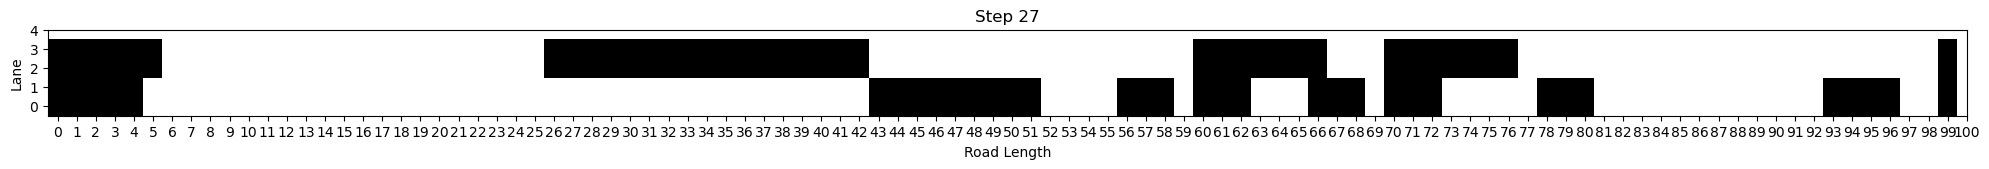

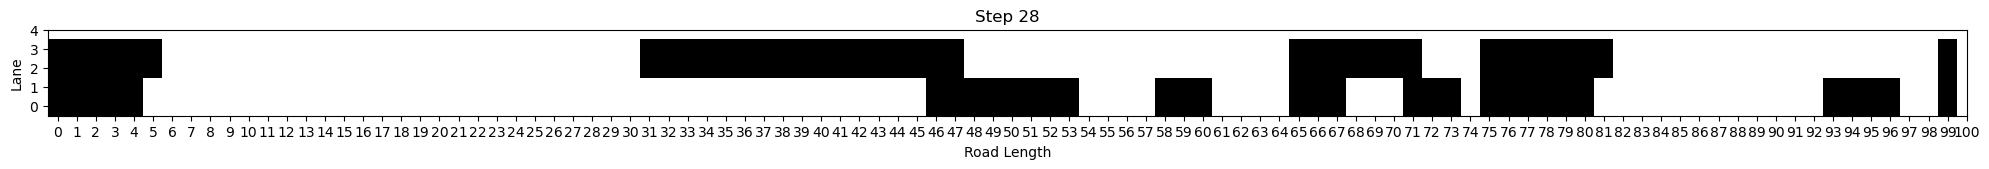

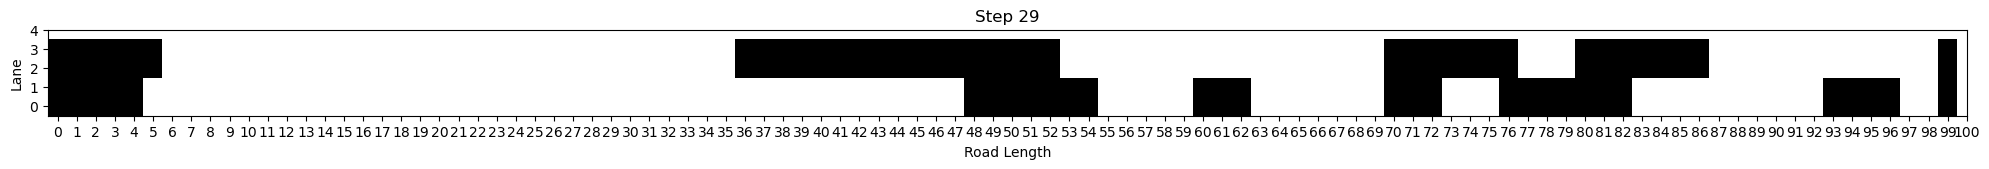

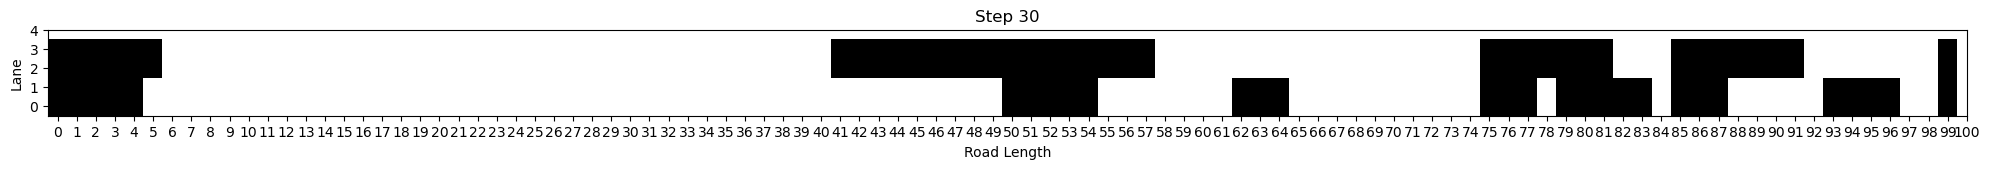

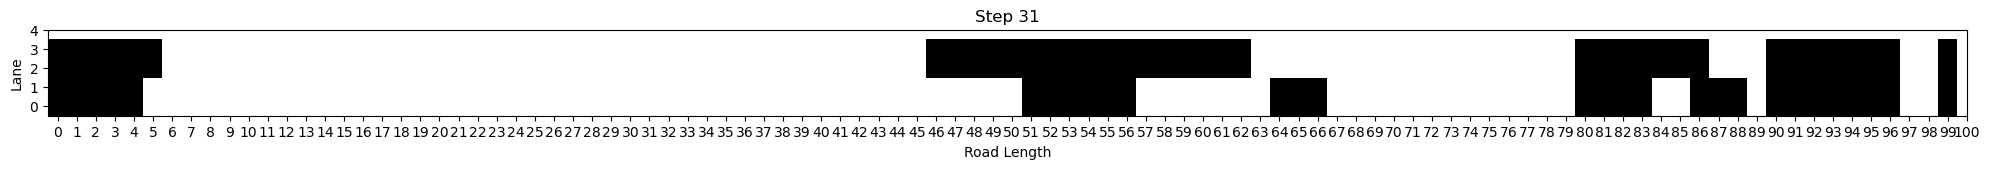

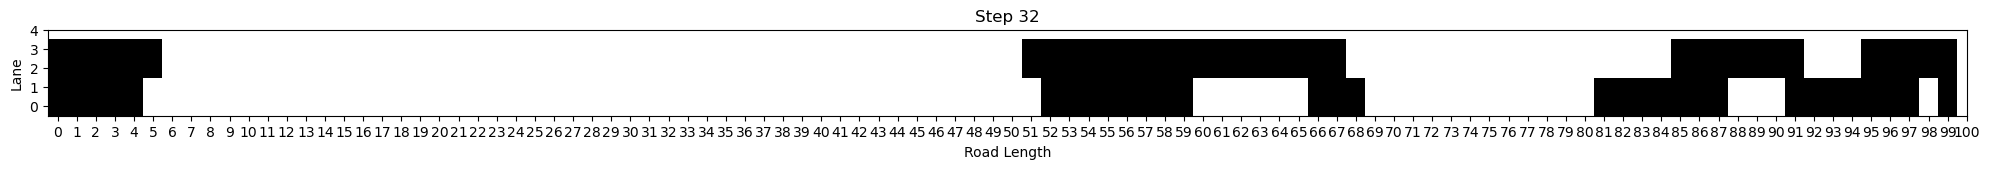

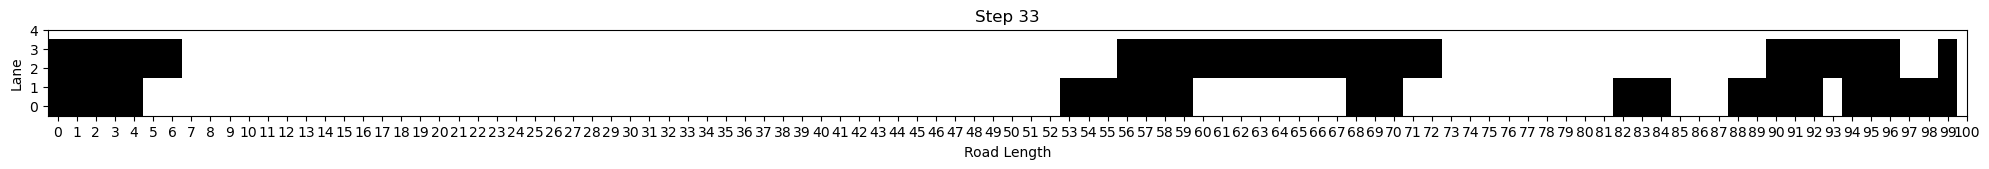

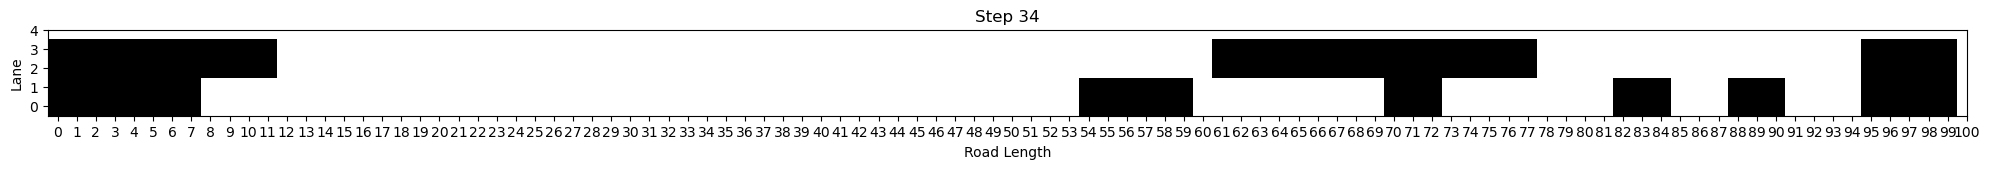

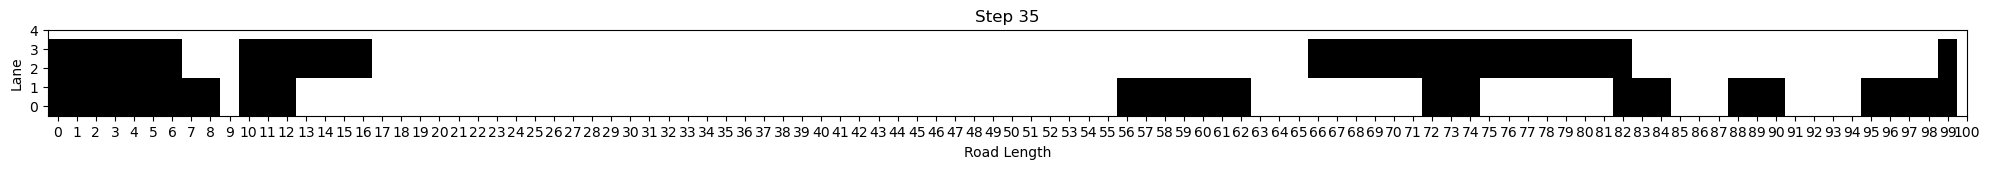

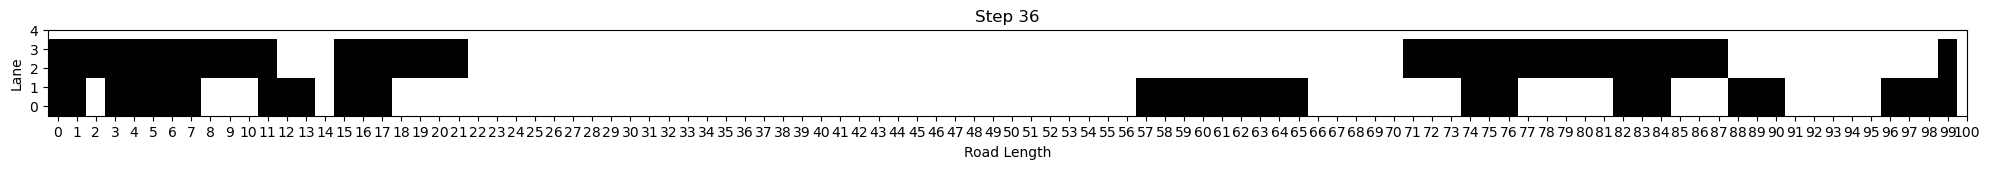

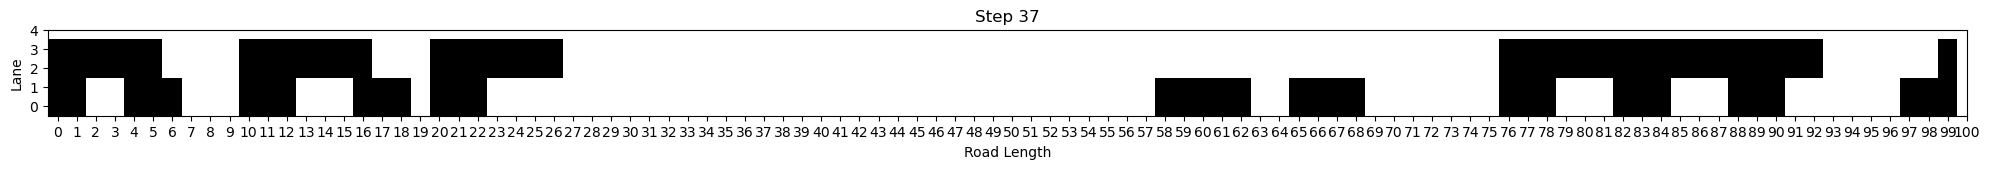

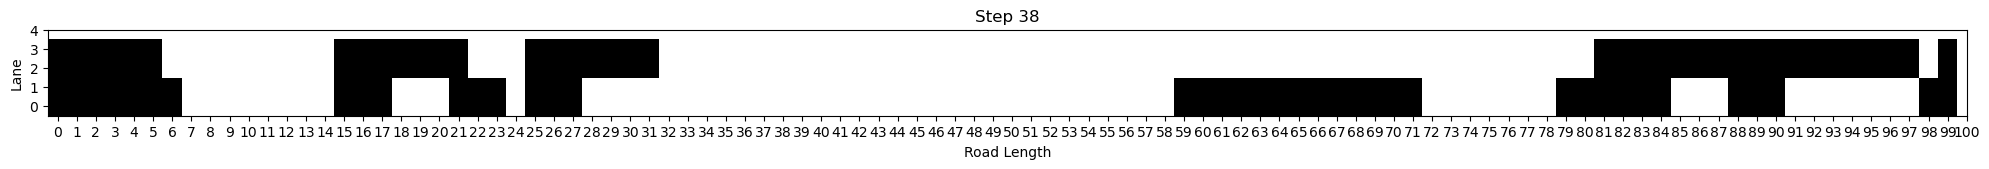

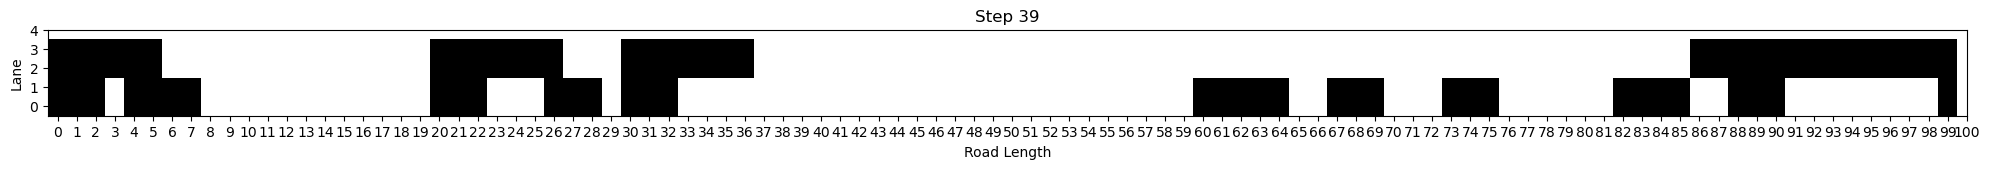

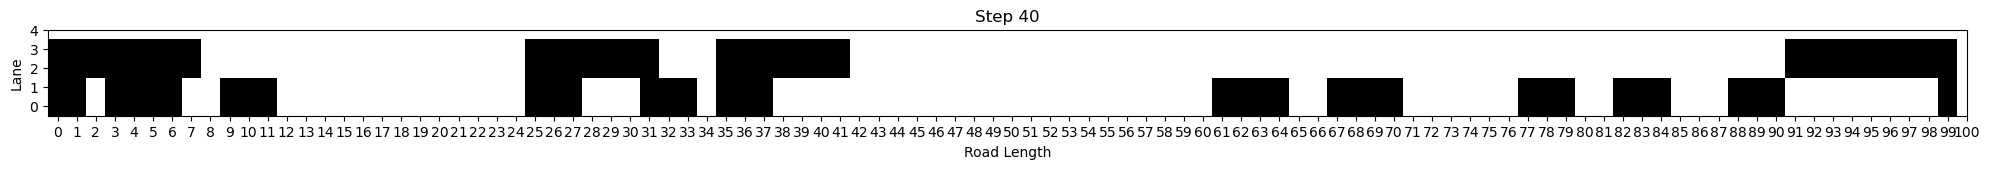

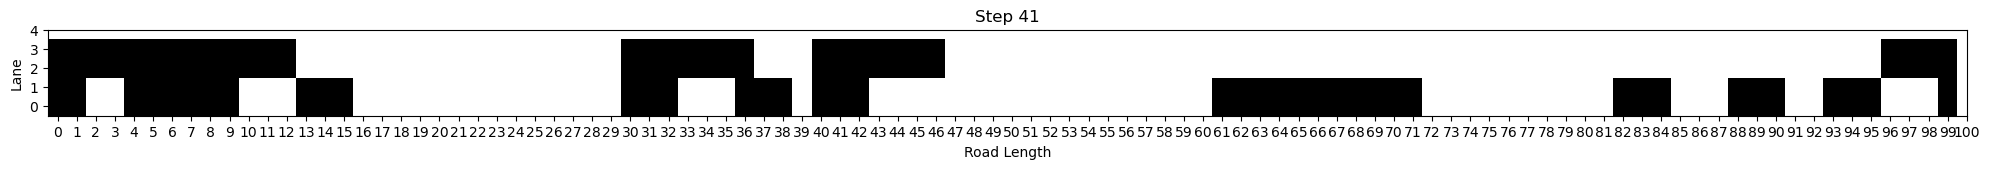

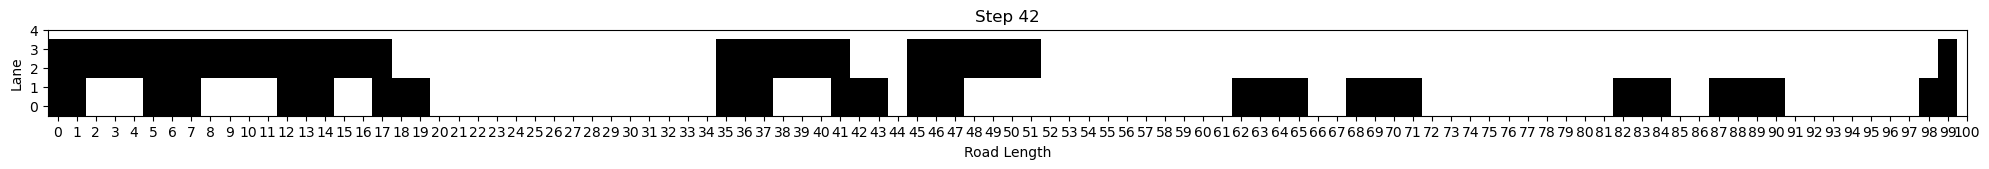

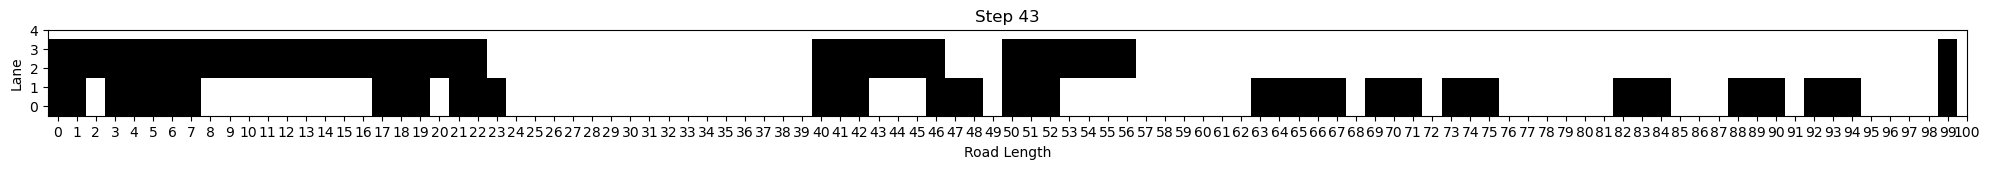

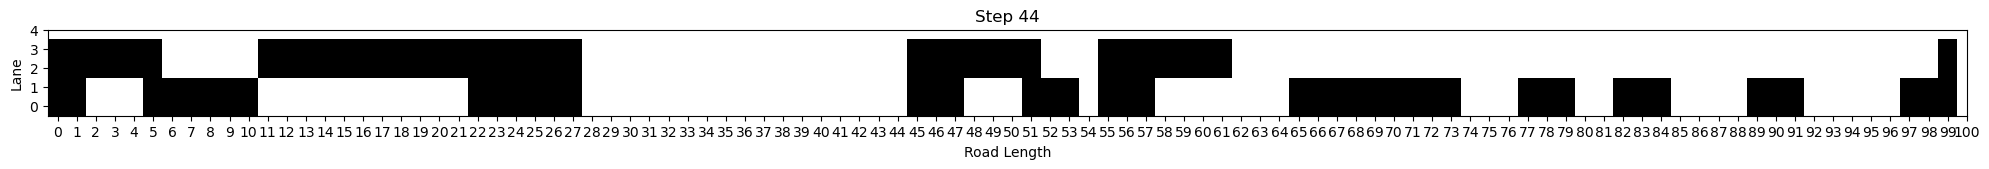

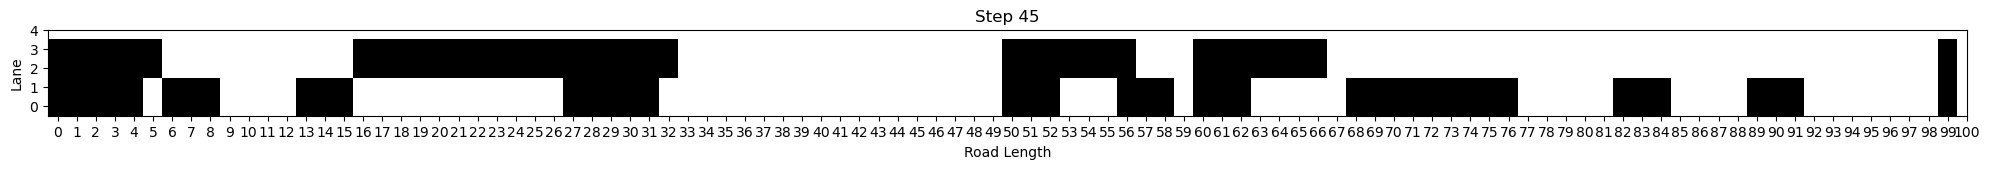

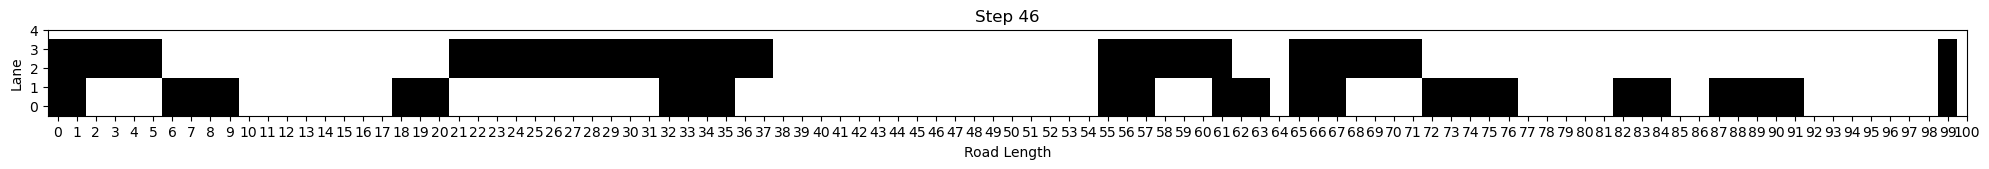

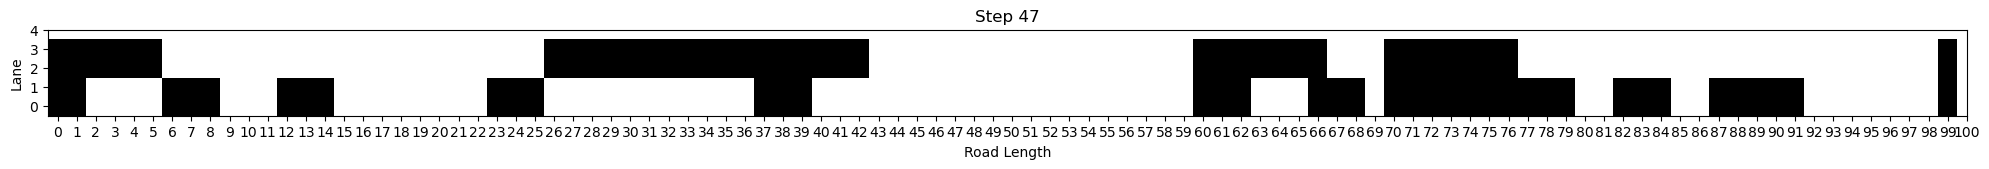

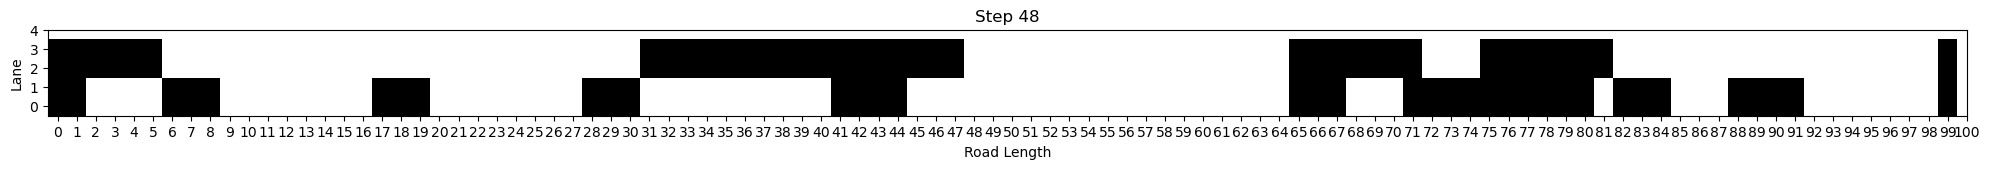

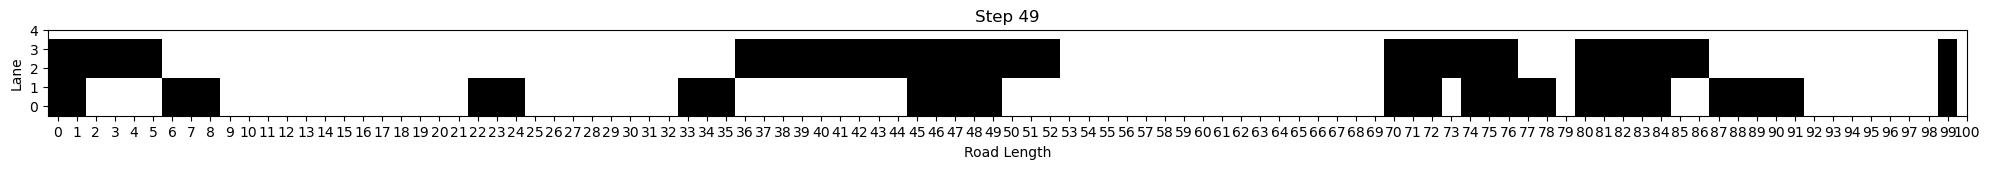

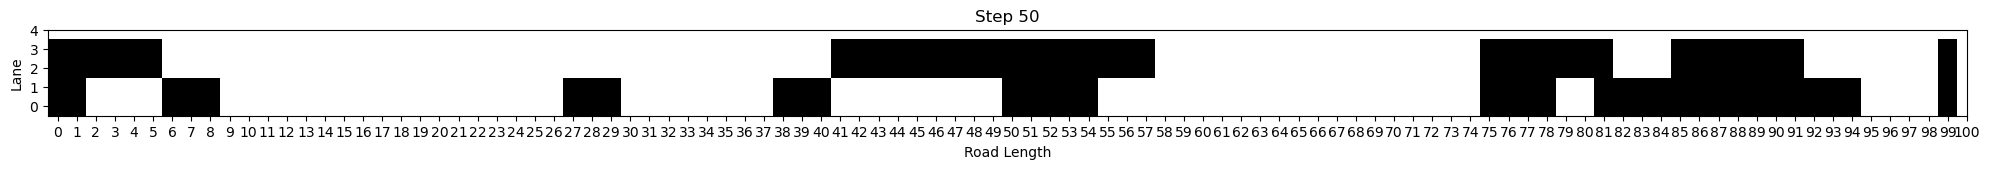

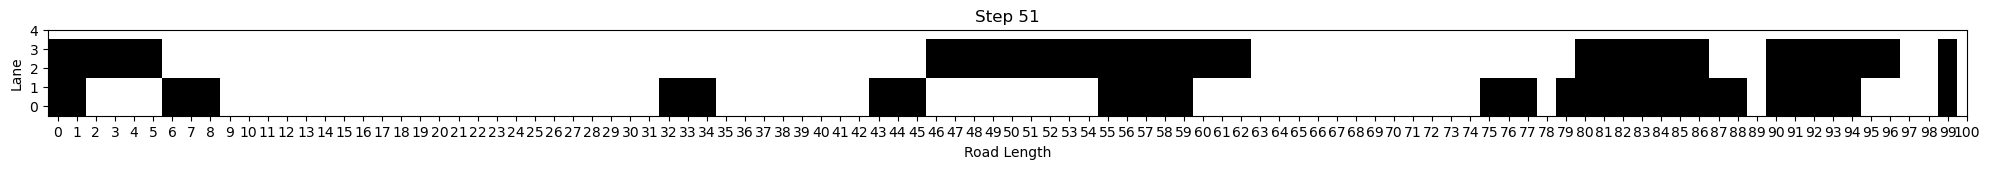

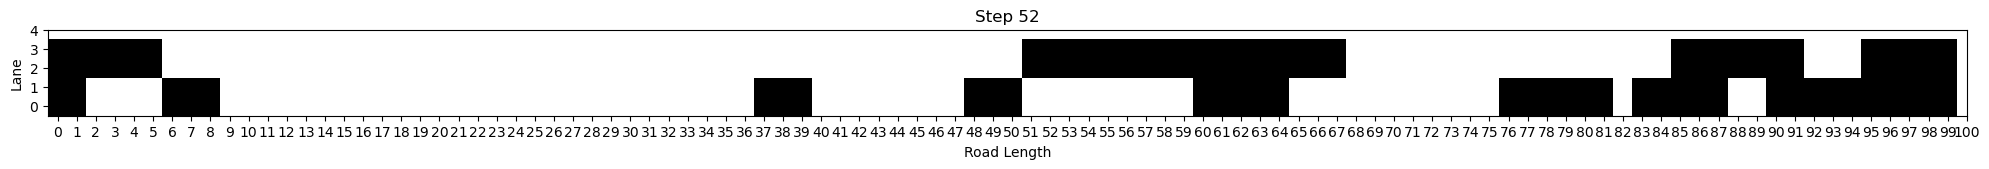

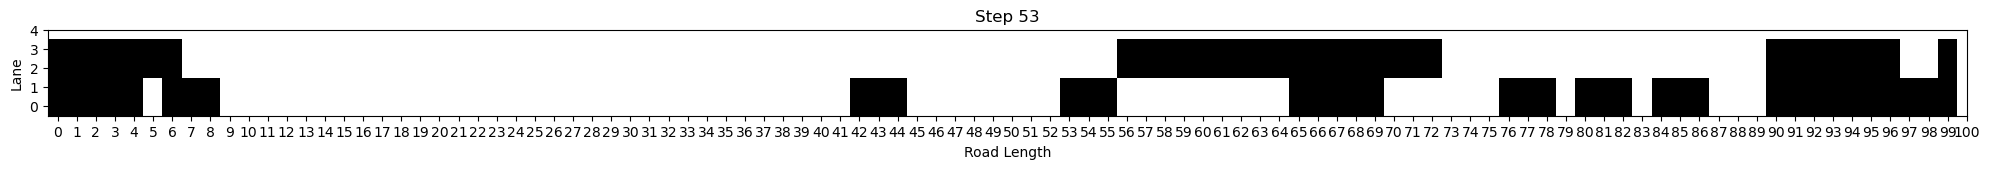

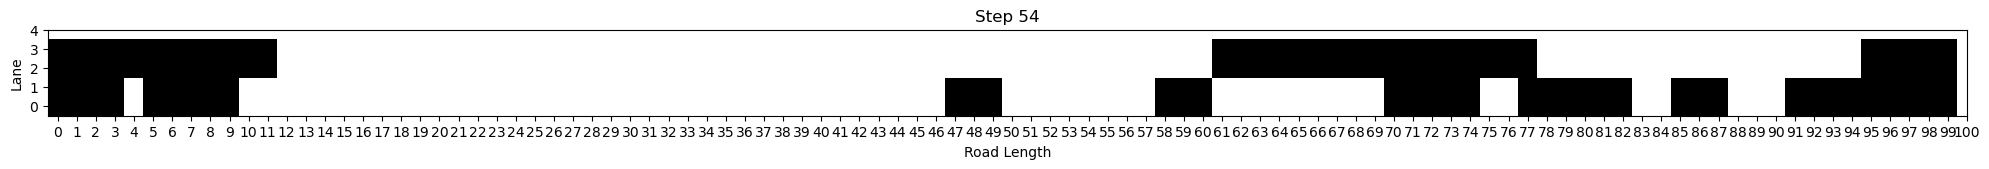

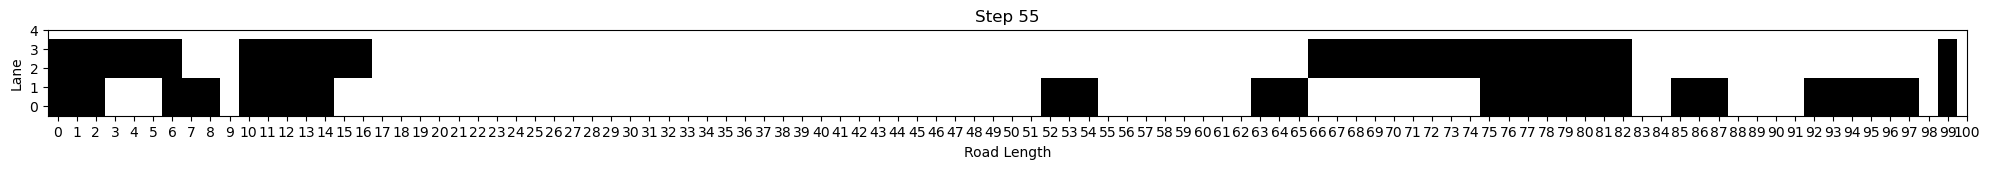

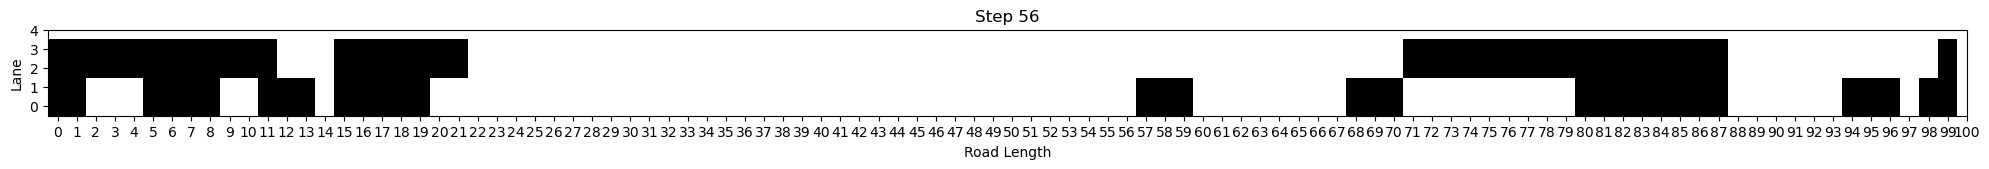

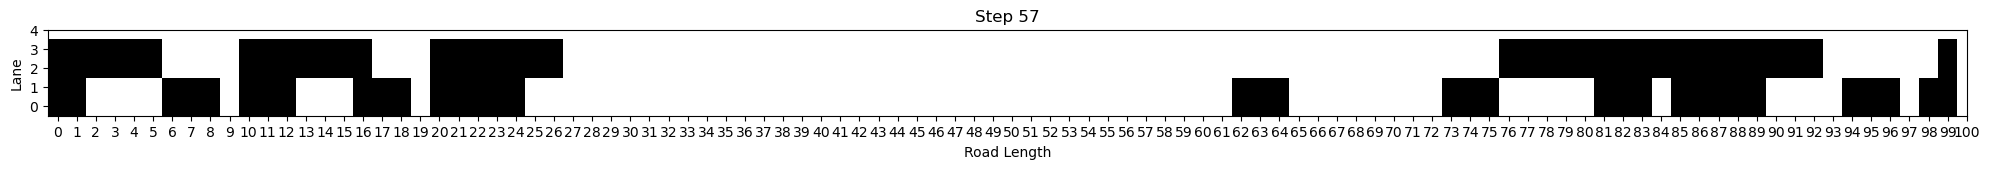

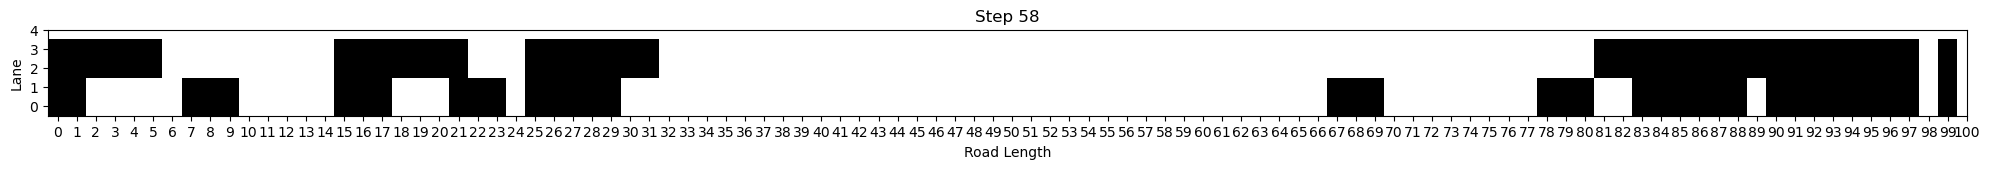

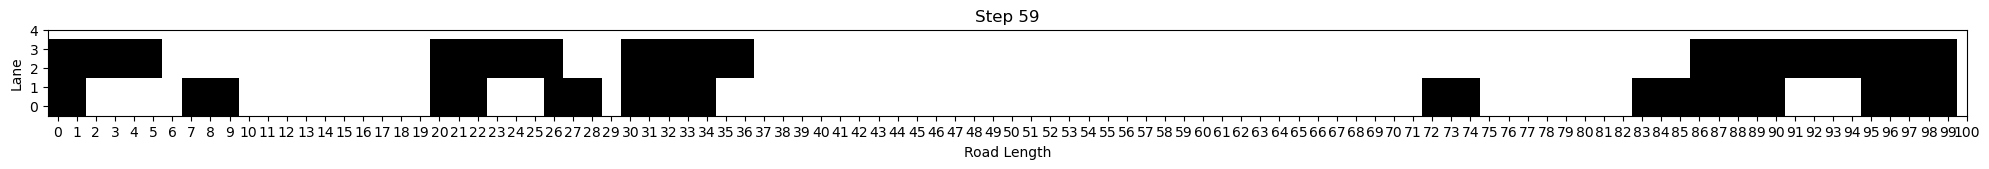

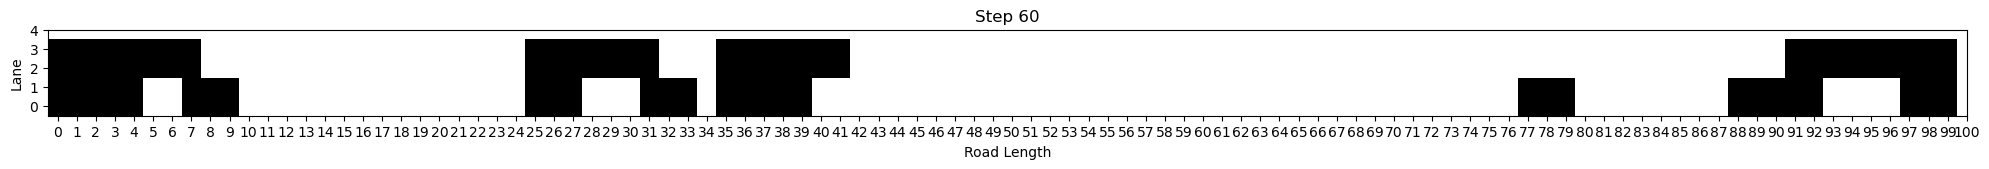

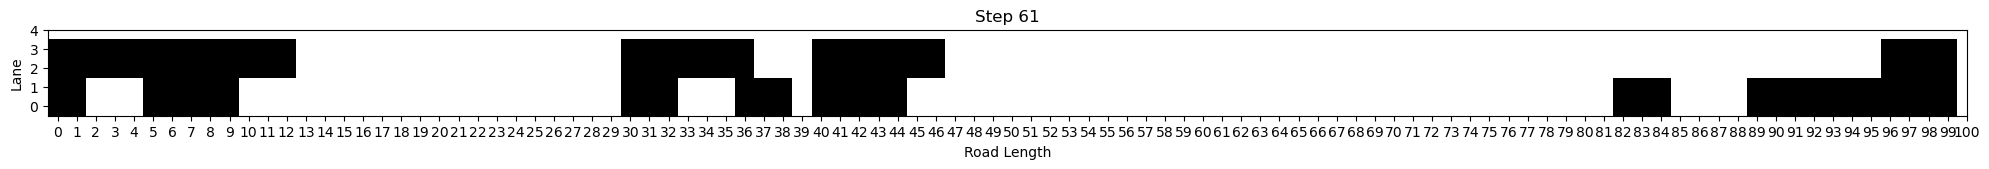

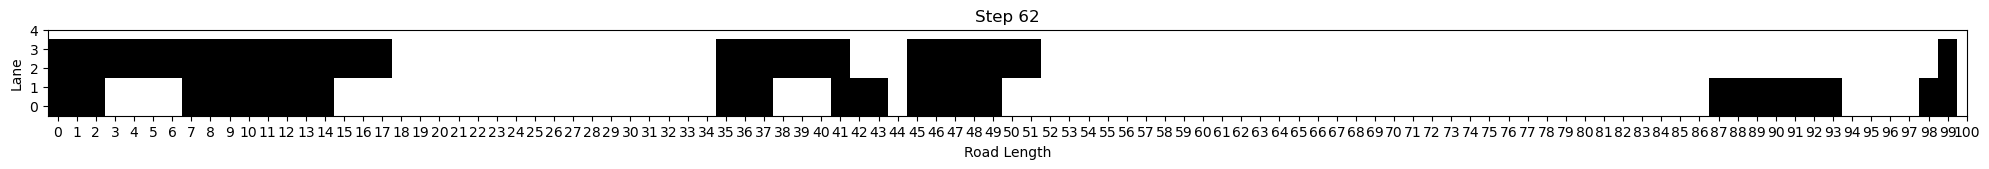

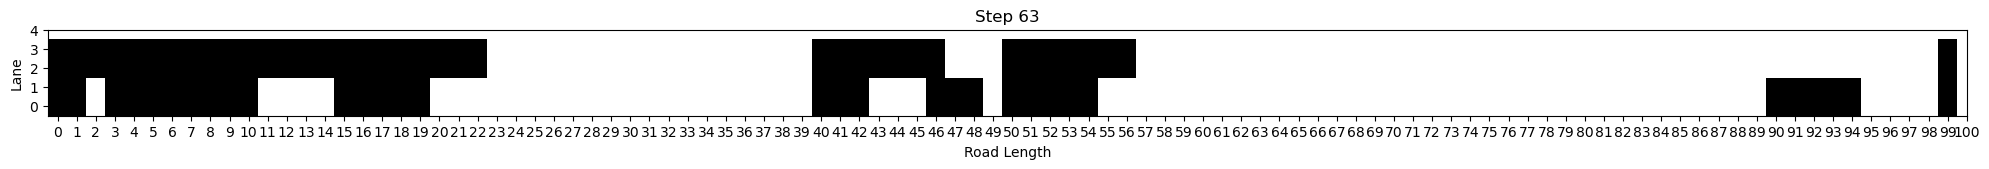

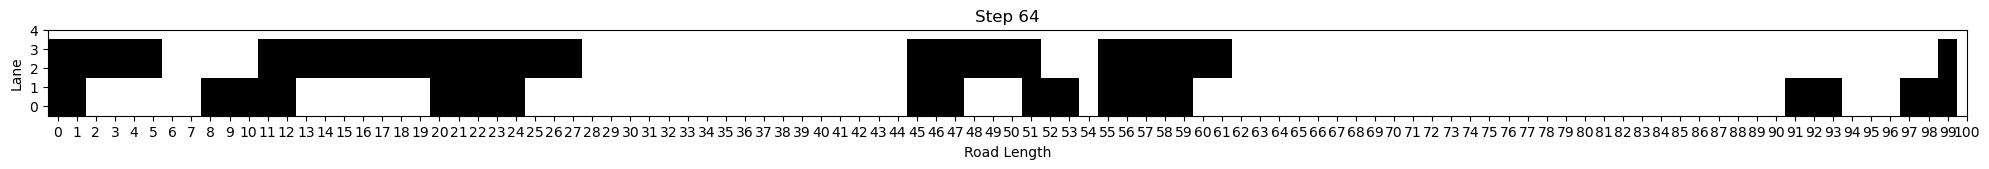

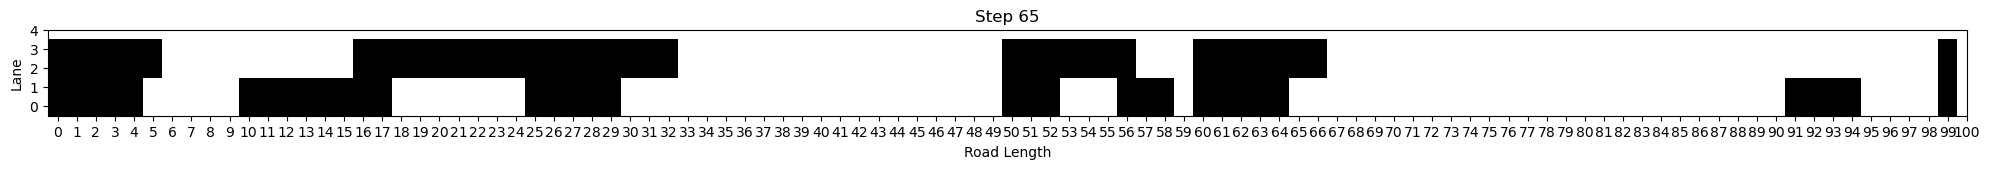

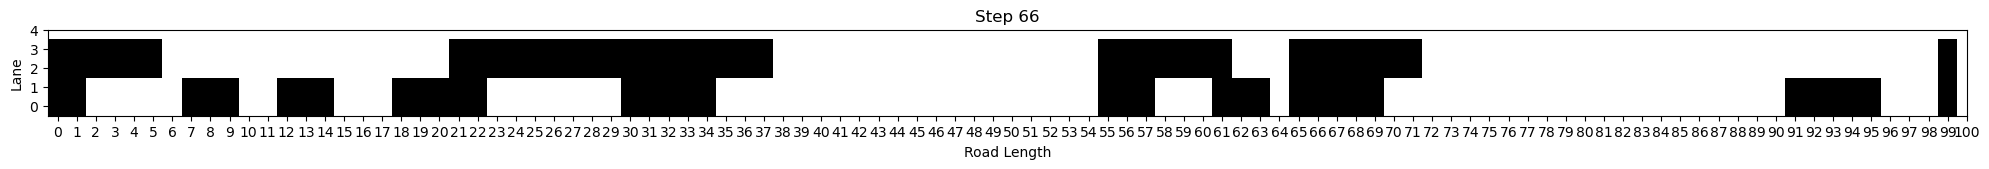

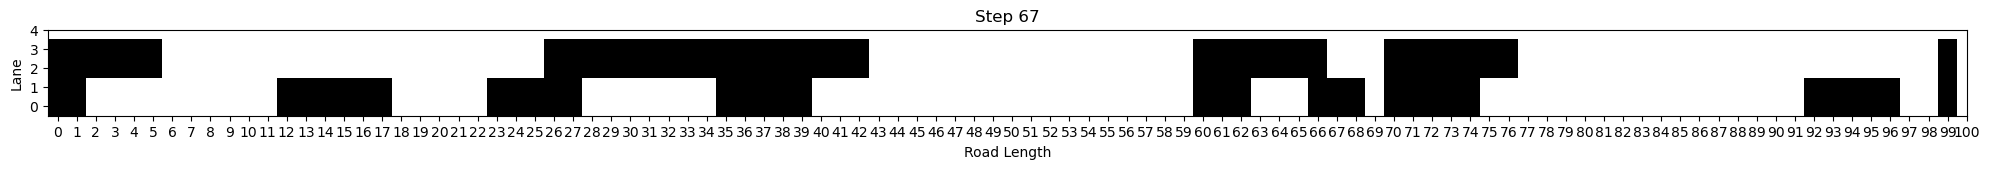

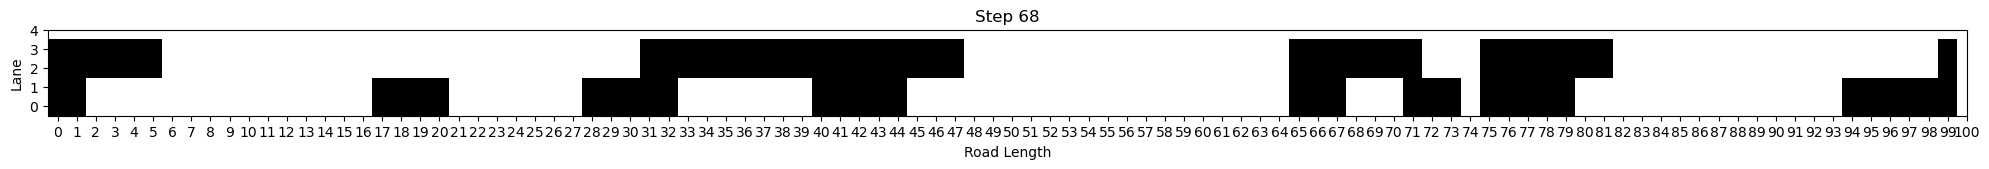

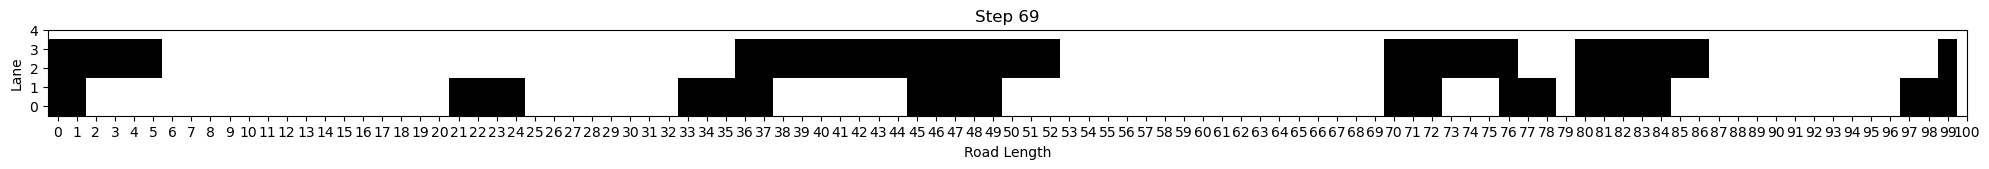

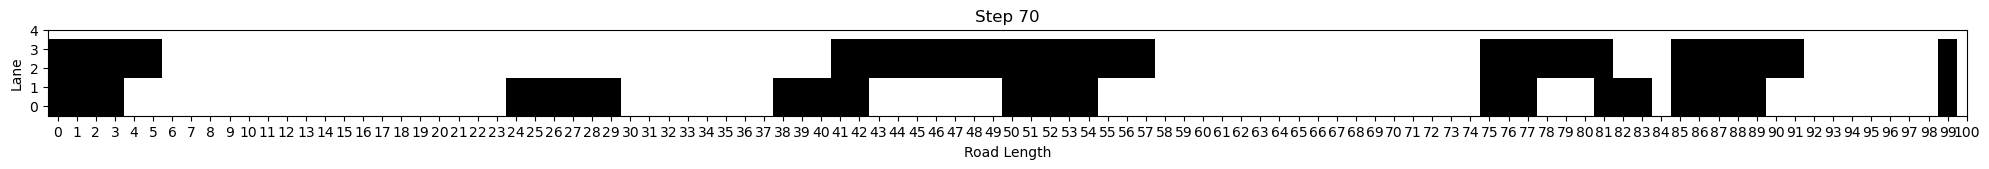

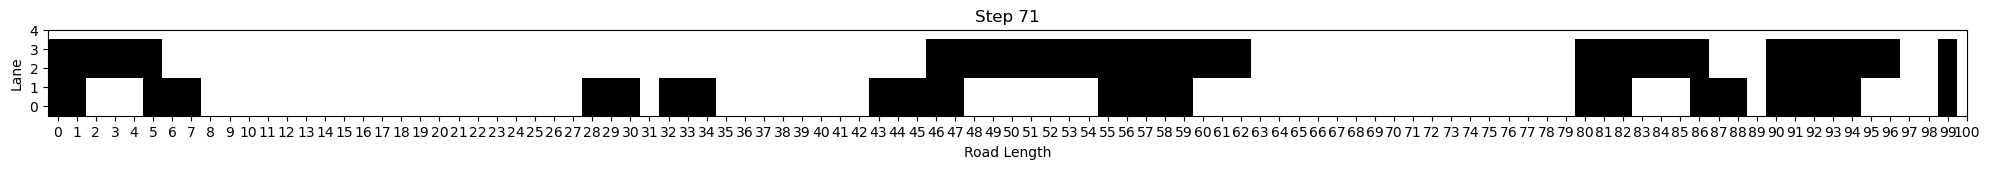

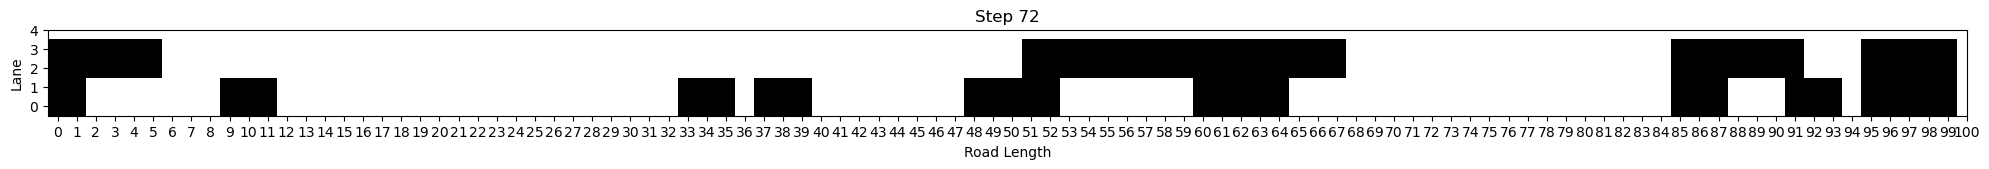

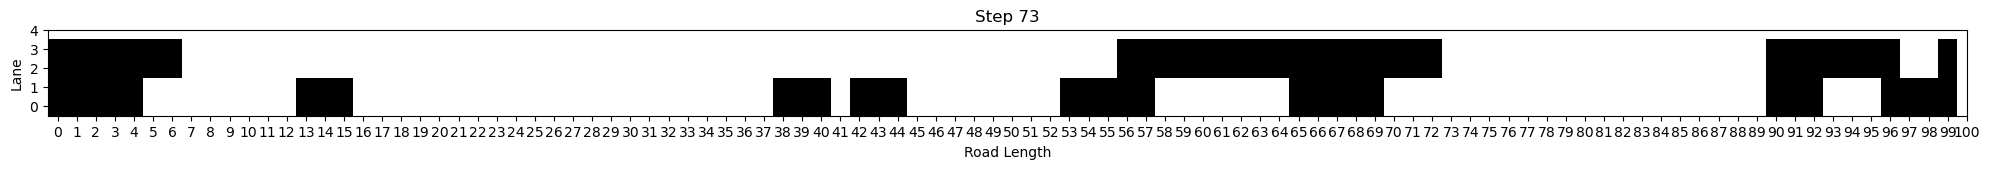

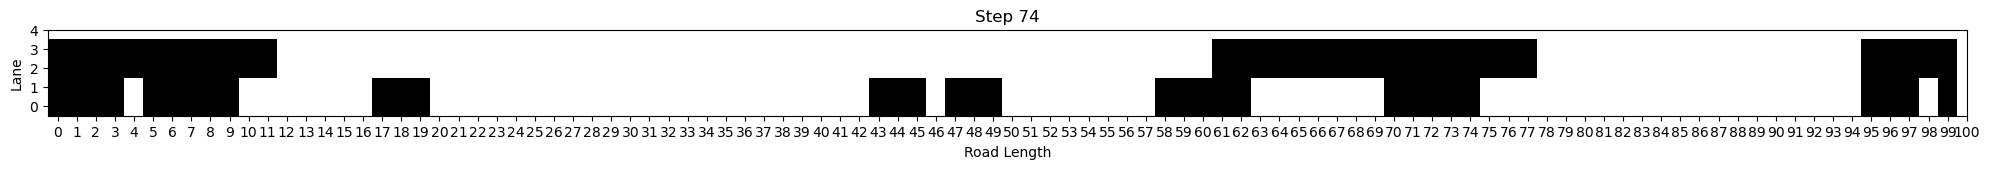

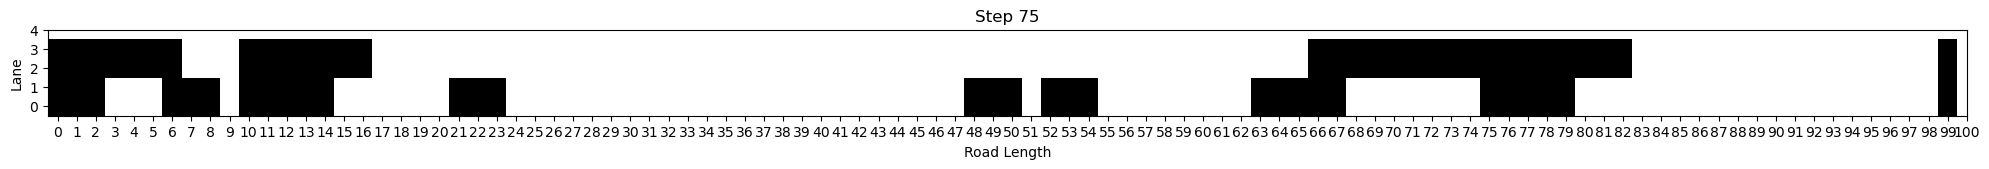

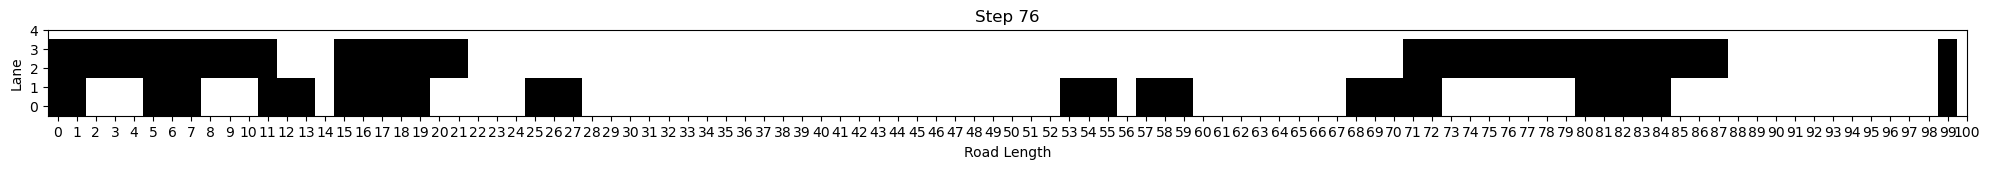

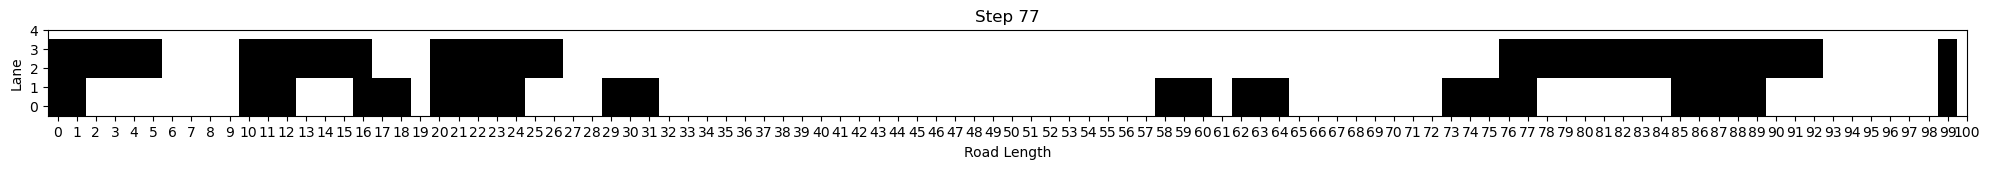

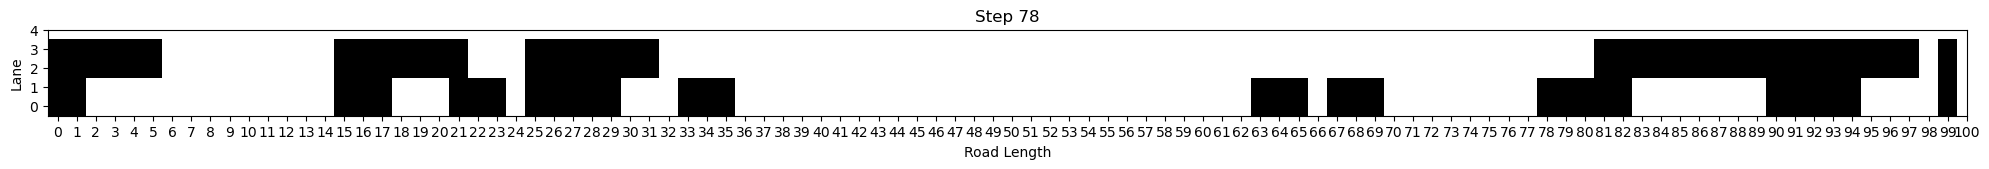

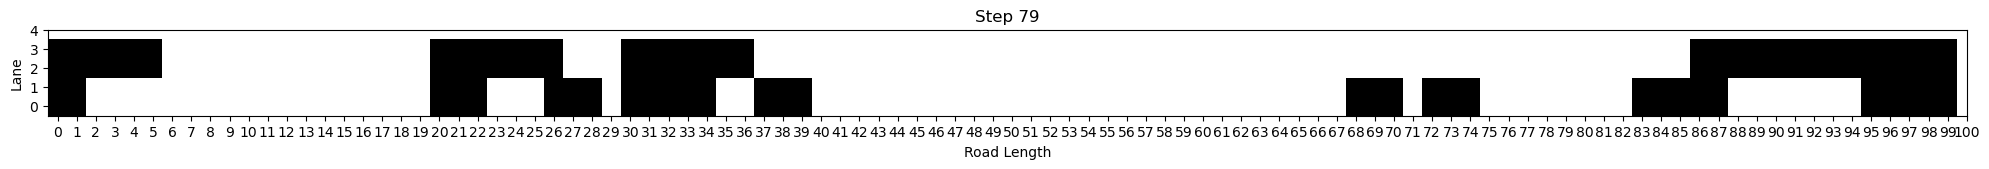

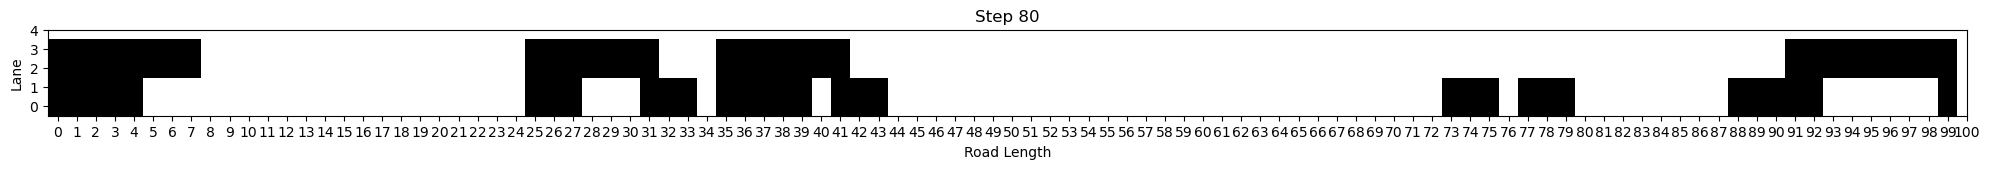

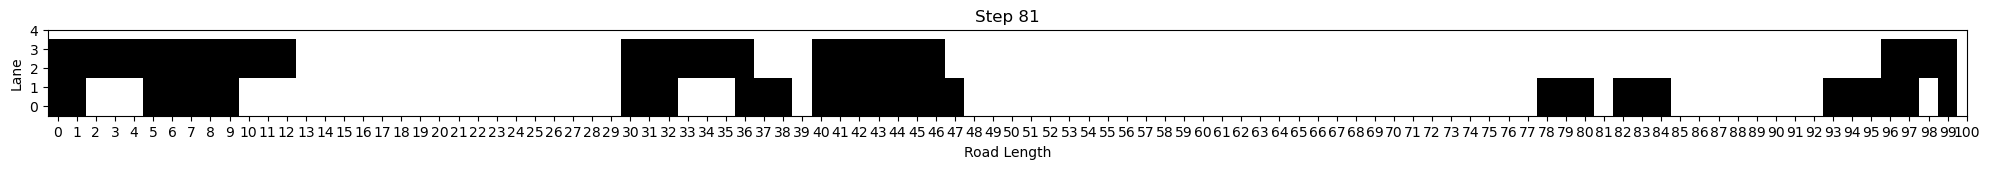

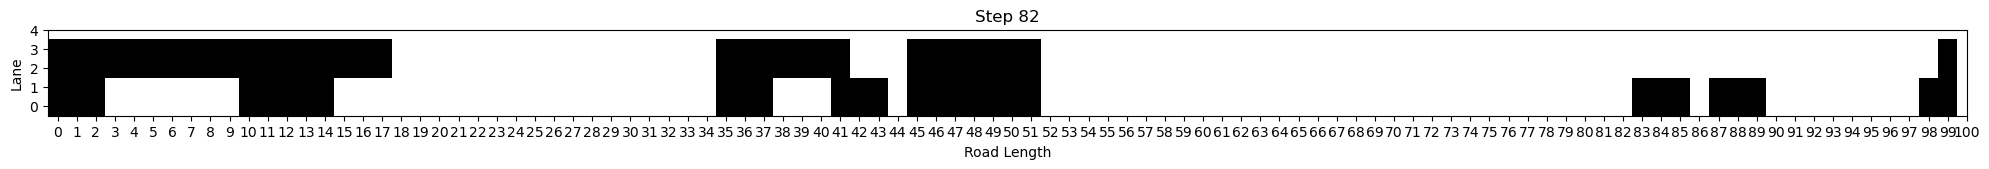

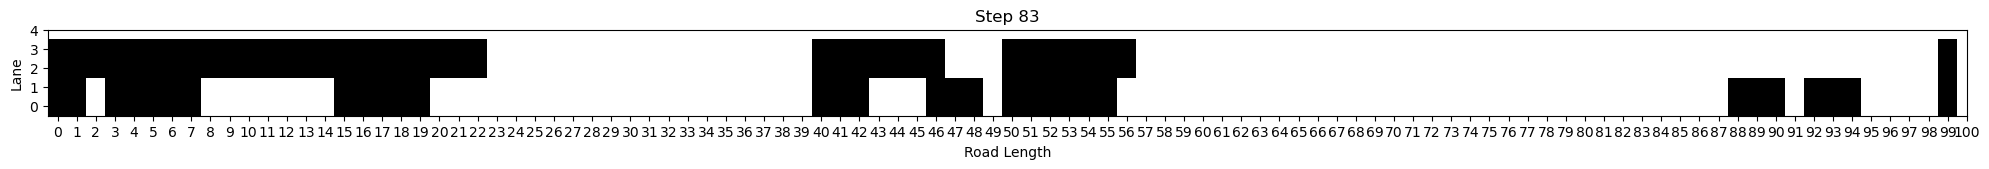

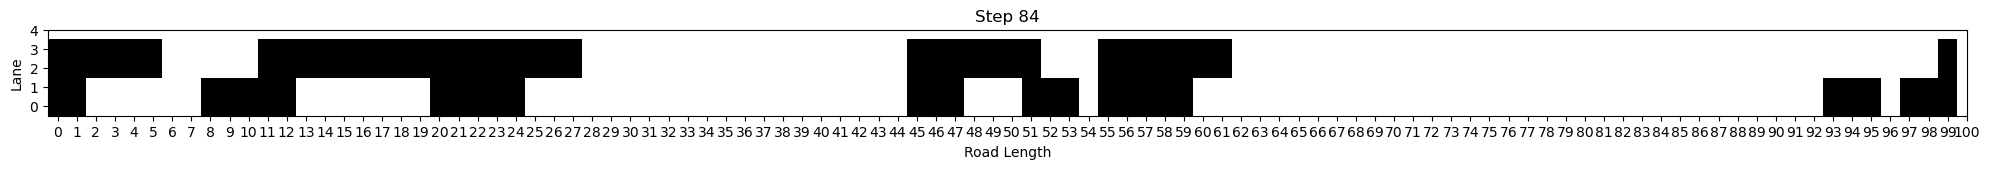

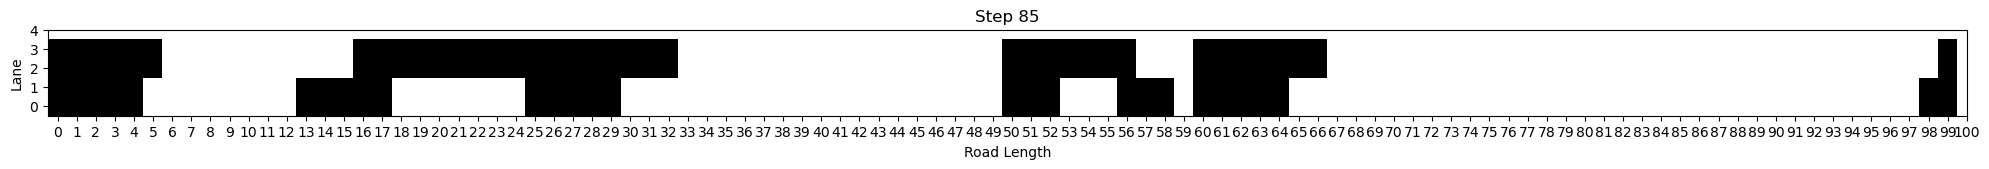

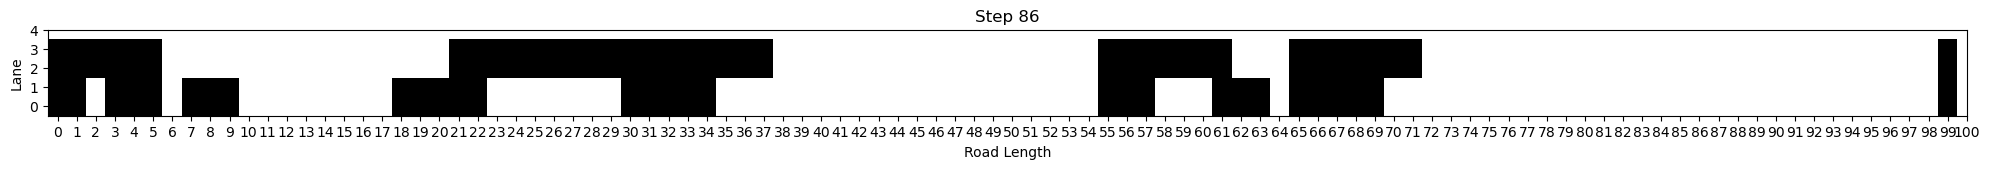

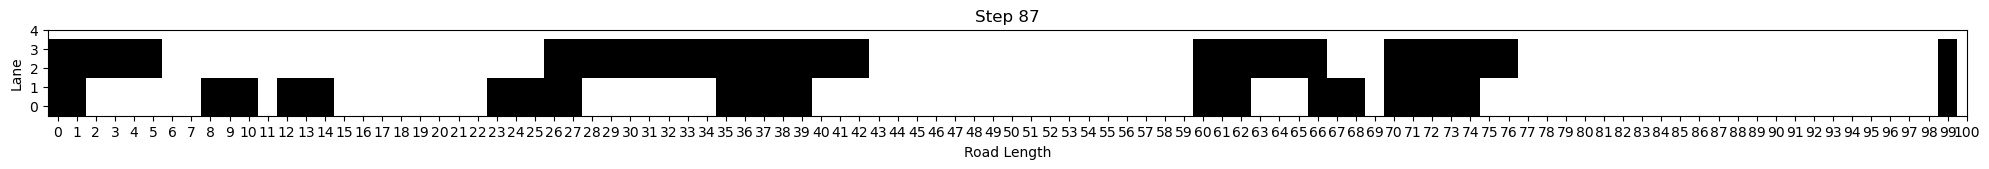

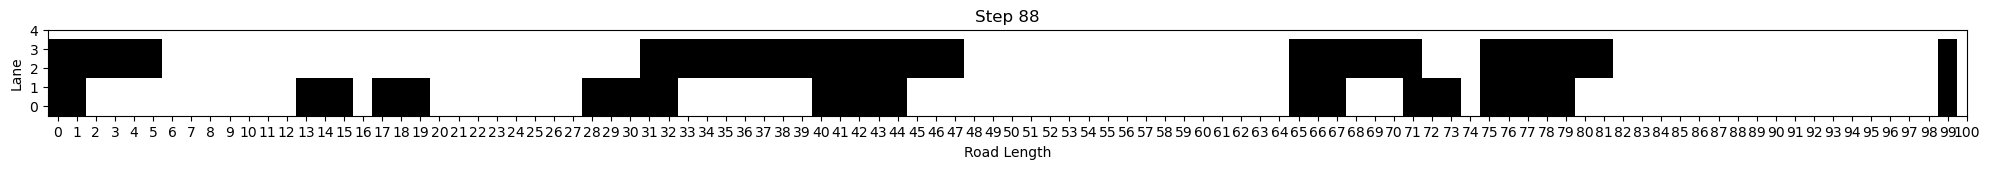

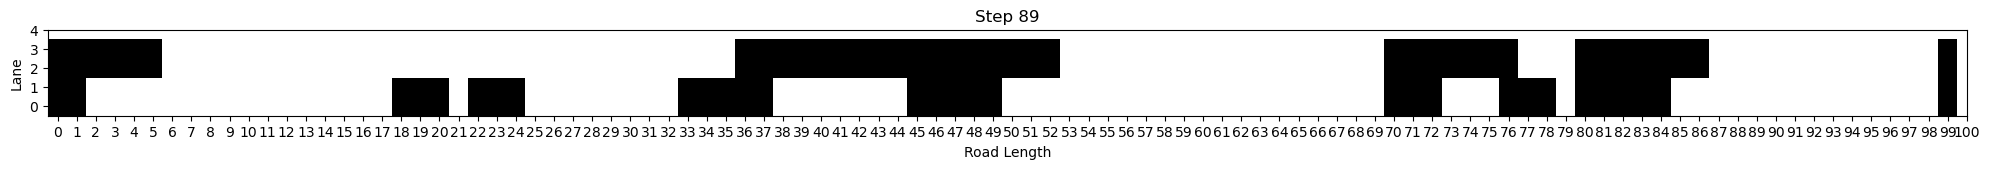

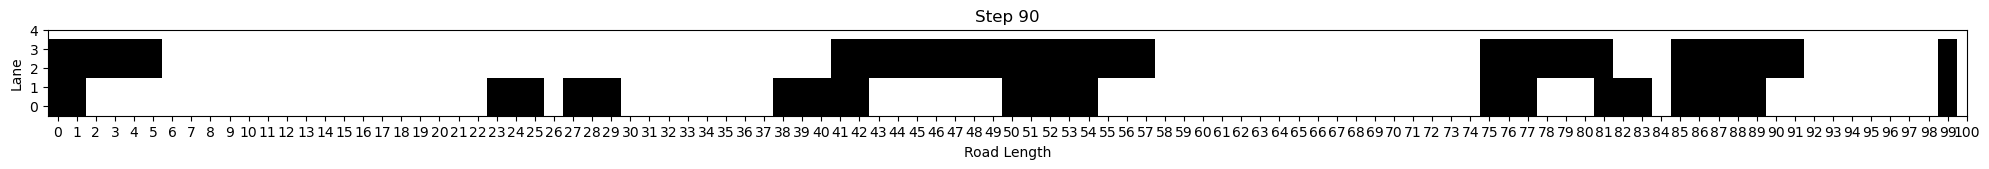

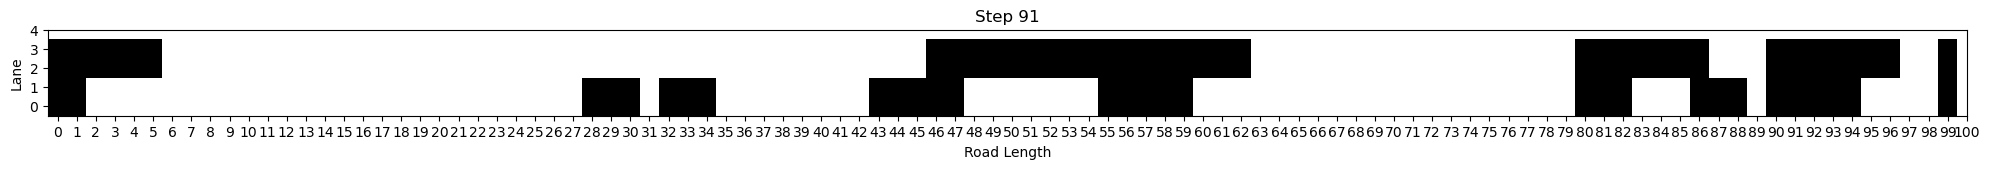

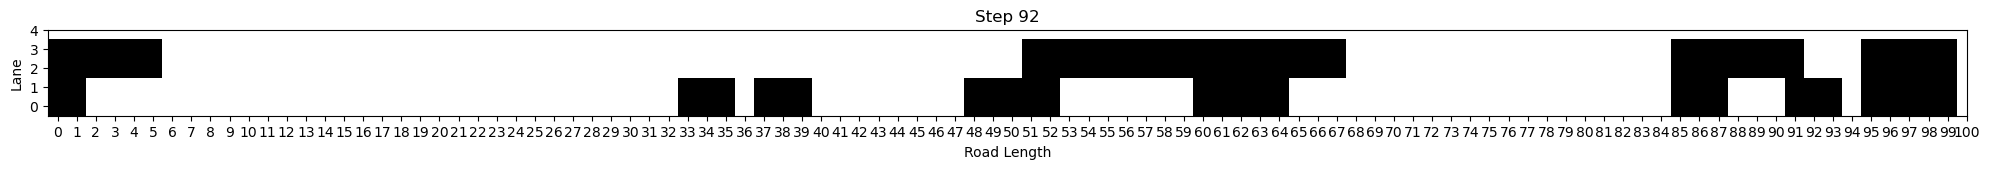

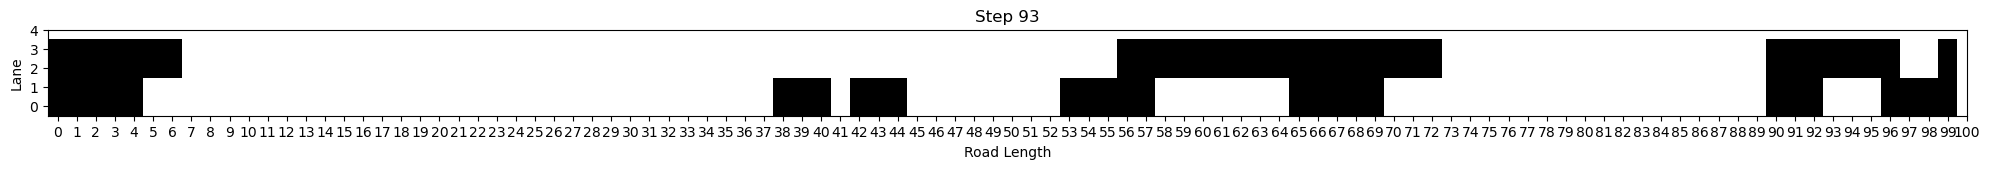

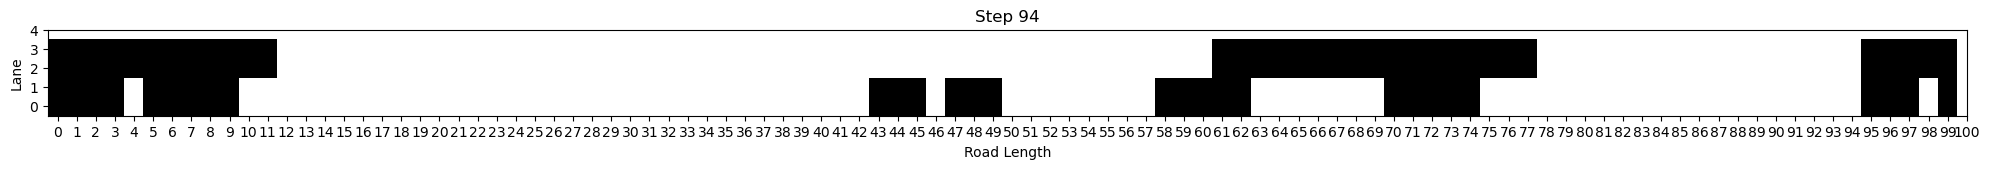

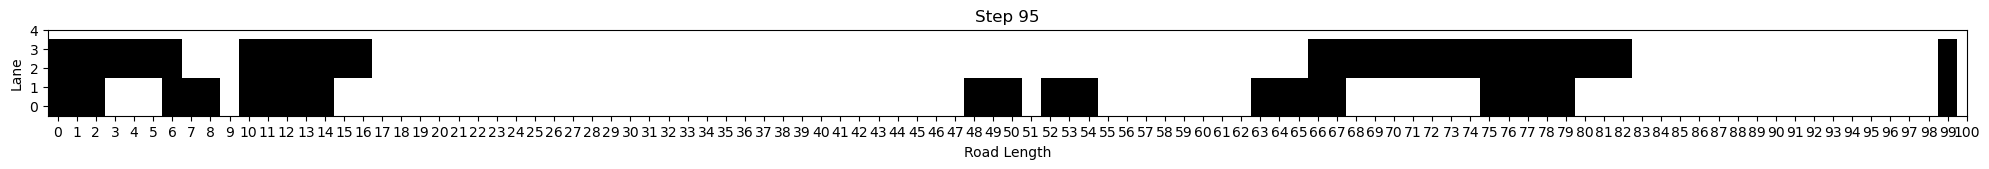

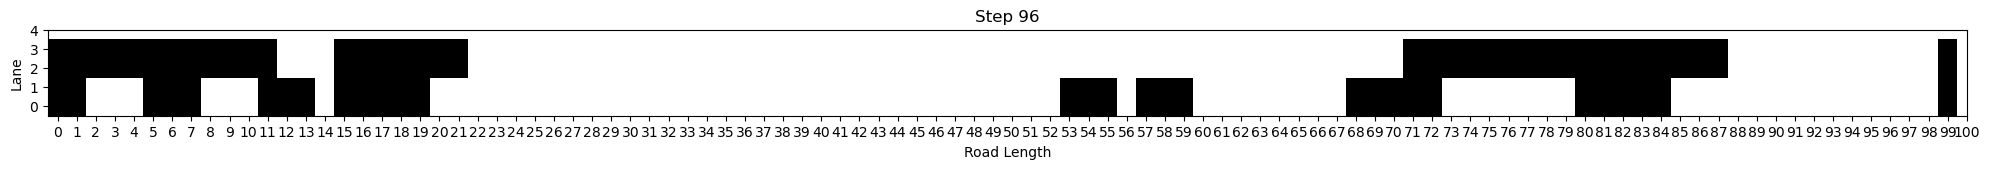

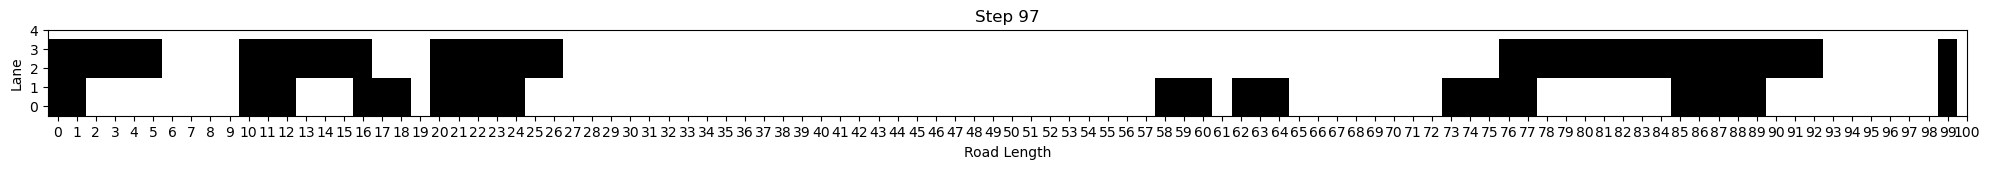

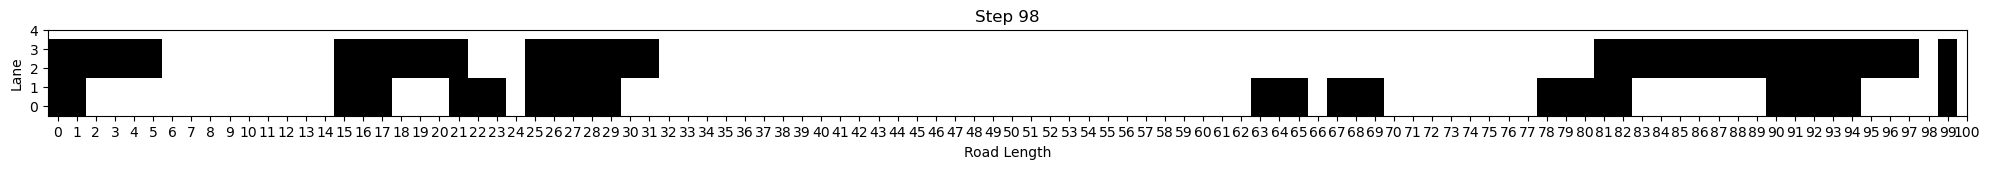

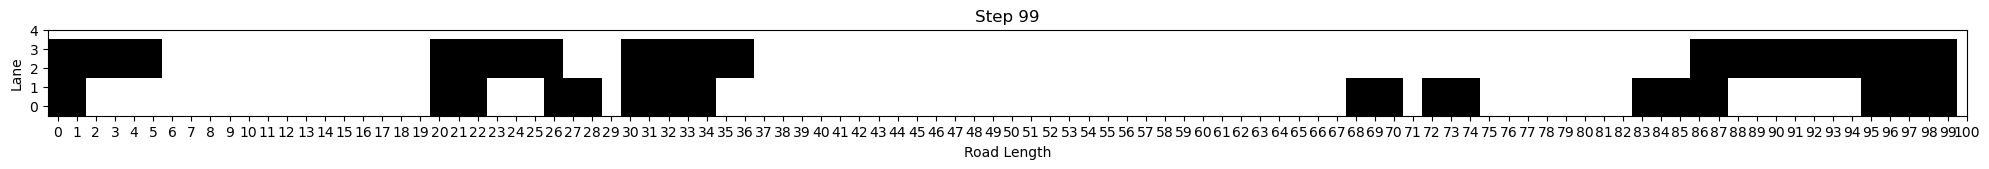

In [51]:
road = Road(road_length=100, road_width=4, speed_limit=5)
simulator = IntraRoadSimulator(road)

density = 1
truck_fraction = 0.1
arrival_rate = 0.05

simulator.initialize_vehicles(density, truck_fraction, 0.2, 0)  # Initialize vehicles


for step in range(100):
    simulator.simulation_step(density, truck_fraction, arrival_rate)
    if step % 1 == 0:
        simulator.visualize(step)


simulator.print_passenger_times()
print(f'Total passenger throughput: {simulator.passenger_throughput}')

This portion is another part.

In [ ]:
road = Road(road_length=100, road_width=4, speed_limit=5)
simulator = IntraRoadSimulator(road)

# Parameters
densities = np.linspace(0, 1, 100)
truck_ratios = [0.1, 0.3, 0.5, 0.7]
truck_lane_changing_probs = [0, 0.3, 0.5]
jeep_lane_changing_prob = 0
arrival_rate = 0.5
num_steps = 100

# Data storage
throughput_data = []
waiting_times_data = defaultdict(list)
travel_times_data = defaultdict(list)
slowdown_counts_data = []

for density in densities:
    for truck_ratio in truck_ratios:
        for truck_lane_change_prob in truck_lane_changing_probs:
            road = Road(road_length=100, road_width=4, speed_limit=5)
            simulator = IntraRoadSimulator(road)
            simulator.initialize_vehicles(density, truck_ratio, truck_lane_change_prob, jeep_lane_changing_prob)
            for step in range(num_steps):
                simulator.simulation_step(density, truck_ratio, arrival_rate)
            throughput_data.append([density, truck_ratio, lane_changing_prob, simulator.passenger_throughput, simulator.vehicle_throughput])
            slowdown_counts_data.append([density, truck_ratio, lane_changing_prob, simulator.slowdown_counts])
            for passenger in simulator.passengers:
                waiting_times_data[density].append(passenger.waiting_time)
                travel_times_data[density].append(passenger.travel_time)

# Save data to CSV
with open('throughput_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Density', 'Truck Ratio', 'Lane Changing Probability', 'Passenger Throughput', 'Vehicle Throughput'])
    writer.writerows(throughput_data)

with open('waiting_times_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Density', 'Waiting Time', 'Frequency'])
    for density, times in waiting_times_data.items():
        for time, freq in zip(*np.unique(times, return_counts=True)):
            writer.writerow([density, time, freq])

with open('travel_times_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Density', 'Travel Time', 'Frequency'])
    for density, times in travel_times_data.items():
        for time, freq in zip(*np.unique(times, return_counts=True)):
            writer.writerow([density, time, freq])

with open('slowdown_counts_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Density', 'Truck Ratio', 'Lane Changing Probability', 'Slowdown Counts'])
    writer.writerows(slowdown_counts_data)

print("Simulation complete. Data saved to CSV files.")